# Practica 1 - EDA COIL 2000

MDC CUNEF 2022-2023 

Pablo Mazariegos Reviriego y 
Mario Sabater Pascual

A continuación vamos a realizar un análisis exploratorio del dataset COIL 2000, el cual se puede obtener en el siguiente link: https://archive-beta.ics.uci.edu/ml/datasets/insurance+company+benchmark+coil+2000#Descriptive

El data set nos presenta una serie de variables teniendo como objetivo predecir quién contratará un seguro de autocaravanas.

1. IMPORTAMOS LIBRERIAS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
import requests
import pandas_profiling
from pandas_profiling.utils.cache import cache_file
from sklearn.impute import KNNImputer
import scipy.stats as ss
import warnings
warnings.filterwarnings('ignore')

1.1 IMPORTAMOS LAS FUNCIONES DEL ARCHIVO "functions.py"

In [2]:
from functions import *

In [3]:
# opciones de visualización
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

2. LEEMOS LOS DATASETS DE LA CARPETA data/raw/

In [4]:
path = "/Users/mariosabater/Desktop/CienciaDatosC1/ML-P1/practica_1/data/raw/"

df_ticdata = pd.read_csv(path + 'ticdata2000.txt', sep = '\t', header= None)
df_ticeval = pd.read_csv(path + 'ticeval2000.txt', sep = '\t', header= None)
df_tictgts = pd.read_csv(path + 'tictgts2000.txt', sep = '\t', header= None)

headers = list(range(1,87))
df_ticdata.columns = headers

#incluimos una nueva columna diferenciando los datos entre train y test. En nuestro caso, ticdata es train.

df_ticdata['87'] = 1
df_tictgts['87'] = 0

In [5]:
# comprobación de que son las mismas columnas
print(len(df_ticdata), 
    len(df_ticeval), 
    len(df_tictgts))

5822 4000 4000


In [6]:
#creamos una lista con los titulos de las variables, siguiendo el diccionario

list_future_variables = ["MOSTYPE", "MAANTHUI", "MGEMOMV",
                        "MGEMLEEF", "MOSHOOFD", "MGODRK",
                        "MGODPR", "MGODOV", "MGODGE",
                        "MRELGE", "MRELSA", "MRELOV", "MFALLEEN",
                        "MFGEKIND", "MFWEKIND", "MOPLHOOG", "MOPLMIDD",
                        "MOPLLAAG", "MBERHOOG", "MBERZELF",
                        "MBERBOER", "MBERMIDD", "MBERARBG", "MBERARBO",
                        "MSKA","MSKB1", "MSKB2", "MSKC",
                        "MSKD", "MHHUUR", "MHKOOP", "MAUT1", "MAUT2",
                        "MAUT0", "MZFONDS", "MZPART", "MINKM30",
                        "MINK3045", "MINK4575", "MINK7512", "MINK123M",
                        "MINKGEM", "MKOOPKLA", "PWAPART", "PWABEDR", "PWALAND",
                        "PPERSAUT", "PBESAUT", "PMOTSCO", "PVRAAUT",
                        "PAANHANG", "PTRACTOR", "PWERKT", "PBROM",
                        "PLEVEN", "PPERSONG", "PGEZONG", "PWAOREG",
                        "PBRAND", "PZEILPL", "PPLEZIER", "PFIETS","PINBOED", 
                        "PBYSTAND","AWAPART","AWABEDR","AWALAND","APERSAUT",
                        "ABESAUT","AMOTSCO","AVRAAUT","AAANHANG","ATRACTOR",
                        "AWERKT","ABROM","ALEVEN","APERSONG","AGEZONG",
                        "AWAOREG","ABRAND","AZEILPL","APLEZIER", "AFIETS",
                        "AINBOED", "ABYSTAND","CARAVAN", "TRAIN"]


list_other_var = ['title']
list_tictgts = ["CARAVAN","TRAIN"]
len(list_future_variables)

87

In [7]:
#incluimos en el dataset los nombres de las columnas
df_ticdata.columns = list_future_variables
df_ticeval.columns = list_future_variables[: - 2]
df_tictgts.columns = list_tictgts

In [8]:
# Juntamos las 3 tablas y comprobamos que se han juntado correctamente comprobando las dimensiones de la tabla
df_merge1 = pd.concat([df_ticeval, df_tictgts], axis = 1, join = "inner")
df_caravans = pd.concat([df_ticdata, df_merge1], axis = 0, join = "inner")

df_caravans = df_caravans.reset_index(col_fill = '', drop=True)
df_caravans.shape

(9822, 87)

In [9]:
# Comparamos las dimensiones de la dataset conjunto con este mismo sin duplicados
print(df_caravans.shape, df_caravans.drop_duplicates().shape)

(9822, 87) (8950, 87)


Observamos que existen 872 valores repetidos. En este caso, dado que no se tratan de personas individuales sino de codigos postales, y al ser la gran mayoria de las variables categoricas que representan rangos de probabilidad, podemos entender que códigos postales próximos tienen valores similares sino iguales. Es por esto que para nuestro análisis decidimos dejar los valores repetidos.

3. OBSERVACIÓN DE LA VARIABLE OBJETIVO CARAVAN

In [10]:
# Cogemos la variable objetivo la cual describe a los posibles interesados en contratar un seguro de caravana.

plot_df_caravans = df_caravans['CARAVAN']\
        .value_counts(normalize = True)\
        .mul(100).rename('percent').reset_index()

plot_df_caravans_conteo = df_caravans['CARAVAN'].value_counts().reset_index()
plot_df_caravans_pc = pd.merge(plot_df_caravans, plot_df_caravans_conteo, 
on = ['index'], how = 'inner')
plot_df_caravans_pc 

index    percent  CARAVAN
0      0  94.033802     9236
1      1   5.966198      586

In [11]:
#hacemos la misma prueba con el dataset de train y test, por el cual observamos que efectivamente esta proporción 
#se cumple y que por tanto, la muestra de test es significativa

#train
plot_df_ticdata = df_ticdata['CARAVAN']\
        .value_counts(normalize = True)\
        .mul(100).rename('percent').reset_index()

plot_df_ticdata_conteo = df_ticdata['CARAVAN'].value_counts().reset_index()
plot_df_ticdata_pc = pd.merge(plot_df_ticdata, plot_df_ticdata_conteo, 
    on = ['index'], how = 'inner')


#test
plot_df_merge1 = df_merge1['CARAVAN']\
        .value_counts(normalize = True)\
        .mul(100).rename('percent').reset_index()

plot_df_merge1_conteo = df_merge1['CARAVAN'].value_counts().reset_index()
plot_df_merge1_pc = pd.merge(plot_df_merge1, plot_df_merge1_conteo,
                             on = ['index'], how = 'inner')


print(plot_df_ticdata_pc)
print(plot_df_merge1_pc)

   index    percent  CARAVAN
0      0  94.022673     5474
1      1   5.977327      348
   index  percent  CARAVAN
0      0    94.05     3762
1      1     5.95      238


In [12]:
fig = px.histogram(plot_df_caravans_pc, x = "index", y = ['percent'])
fig.show()
fig_train = px.histogram(plot_df_ticdata_pc, x = "index", y = ['percent'])
fig_train.show()
fig_test = px.histogram(plot_df_merge1_pc, x = "index", y = ['percent'])
fig_test.show()

Confirmamos que ambas muestras tienen una distribución similar y por tanto continuamos con nuestra muestra de train para la realización del EDA dataset.

# A PARTIR DE AHORA SOLO UTILIZAMOS EL DATASET DE TRAIN: df_ticdata

3. ANALISIS DE LAS VARIABLES DEL DATASET df_ticdata

In [13]:
# Tipos de datos
df_ticdata.dtypes.to_dict()

{'MOSTYPE': dtype('int64'),
 'MAANTHUI': dtype('int64'),
 'MGEMOMV': dtype('int64'),
 'MGEMLEEF': dtype('int64'),
 'MOSHOOFD': dtype('int64'),
 'MGODRK': dtype('int64'),
 'MGODPR': dtype('int64'),
 'MGODOV': dtype('int64'),
 'MGODGE': dtype('int64'),
 'MRELGE': dtype('int64'),
 'MRELSA': dtype('int64'),
 'MRELOV': dtype('int64'),
 'MFALLEEN': dtype('int64'),
 'MFGEKIND': dtype('int64'),
 'MFWEKIND': dtype('int64'),
 'MOPLHOOG': dtype('int64'),
 'MOPLMIDD': dtype('int64'),
 'MOPLLAAG': dtype('int64'),
 'MBERHOOG': dtype('int64'),
 'MBERZELF': dtype('int64'),
 'MBERBOER': dtype('int64'),
 'MBERMIDD': dtype('int64'),
 'MBERARBG': dtype('int64'),
 'MBERARBO': dtype('int64'),
 'MSKA': dtype('int64'),
 'MSKB1': dtype('int64'),
 'MSKB2': dtype('int64'),
 'MSKC': dtype('int64'),
 'MSKD': dtype('int64'),
 'MHHUUR': dtype('int64'),
 'MHKOOP': dtype('int64'),
 'MAUT1': dtype('int64'),
 'MAUT2': dtype('int64'),
 'MAUT0': dtype('int64'),
 'MZFONDS': dtype('int64'),
 'MZPART': dtype('int64'),
 'MINK

3.1 ANÁLISIS DE NULOS

In [14]:
# miramos si hay nulos en nuestra dataset de train

pd_series_null_columns = df_ticdata.isnull().sum().sort_values(ascending = False)
pd_series_null_rows = df_ticdata.isnull().sum(axis = 1).sort_values(ascending = False)

print(pd_series_null_columns.shape, pd_series_null_rows.shape)

pd_null_columnas = pd.DataFrame(pd_series_null_columns,
    columns = ['nulos_columnas'])     
pd_null_filas = pd.DataFrame(pd_series_null_rows,
    columns = ['nulos_filas'])  


pd_null_columnas['porcentaje_columnas'] = pd_null_columnas['nulos_columnas'] / df_ticdata.shape[0]
pd_null_filas['porcentaje_filas'] = pd_null_filas['nulos_filas'] / df_ticdata.shape[1]

(87,) (5822,)


In [15]:
dame_variables_categoricas(df_ticdata)

(['MAANTHUI',
  'MGEMOMV',
  'MGEMLEEF',
  'MGODOV',
  'MRELSA',
  'MBERZELF',
  'MSKD',
  'MAUT2',
  'MINK123M',
  'MKOOPKLA',
  'PWAPART',
  'PWABEDR',
  'PWALAND',
  'PPERSAUT',
  'PBESAUT',
  'PMOTSCO',
  'PVRAAUT',
  'PAANHANG',
  'PTRACTOR',
  'PWERKT',
  'PBROM',
  'PPERSONG',
  'PGEZONG',
  'PWAOREG',
  'PBRAND',
  'PZEILPL',
  'PPLEZIER',
  'PFIETS',
  'PINBOED',
  'PBYSTAND',
  'AWAPART',
  'AWABEDR',
  'AWALAND',
  'APERSAUT',
  'ABESAUT',
  'AMOTSCO',
  'AVRAAUT',
  'AAANHANG',
  'ATRACTOR',
  'AWERKT',
  'ABROM',
  'ALEVEN',
  'APERSONG',
  'AGEZONG',
  'AWAOREG',
  'ABRAND',
  'AZEILPL',
  'APLEZIER',
  'AFIETS',
  'AINBOED',
  'ABYSTAND',
  'CARAVAN',
  'TRAIN'],
 ['MOSTYPE',
  'MOSHOOFD',
  'MGODRK',
  'MGODPR',
  'MGODGE',
  'MRELGE',
  'MRELOV',
  'MFALLEEN',
  'MFGEKIND',
  'MFWEKIND',
  'MOPLHOOG',
  'MOPLMIDD',
  'MOPLLAAG',
  'MBERHOOG',
  'MBERBOER',
  'MBERMIDD',
  'MBERARBG',
  'MBERARBO',
  'MSKA',
  'MSKB1',
  'MSKB2',
  'MSKC',
  'MHHUUR',
  'MHKOOP',
  'MAU

Utilizando una funcion dandole 10 unidades de valores únicos nos sale un resultado erroneo, ya que revisando el dicccionario observamos que esta considerando variables numericas como "MGEMOMV" y falla a la hora de reconocer la variable "MOSTYPE", ya que es categorica con 42 posibles resultados. En definitiva, no podemos utilizar esta función y debemos identificar las variables categoricas y numericass revisando el dataset y el diccionario. 

3.2 CAMBIO DE LA VARIABLE EDAD DE CATEGORICA A NUMERICA "MGEMLEEF"

In [16]:
# Cambio de una variable categorica a numerica por la media de sus rangos.

df_ticdata.MGEMLEEF.replace({1: 25, 2: 35, 3:45, 4:55, 5:65, 6:75}, 
    inplace = True)

df_ticdata.MGEMLEEF.unique()

array([35, 45, 25, 55, 65, 75])

3.3 CORRELACIÓN DE LAS VARIABLES (SPEARMAN)

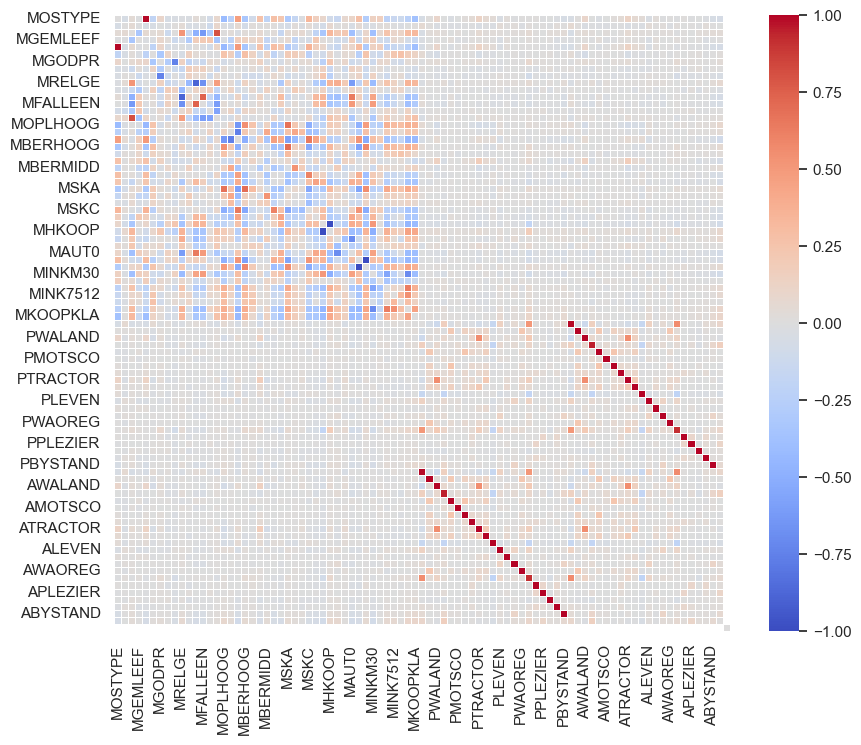

In [17]:
#Llamamos a la función desde functions.py

get_corr_matrix(dataset = df_ticdata, size_figure = [10,8])

#utilizamos la correlación de Spearman

Observamos una gran correlación en la equina de arriba a la izquienda (entre MOSTYPE y MOSHOOFD) y en la parte del abajo a la derecha. Ampliamos este sector para obtener más detalle

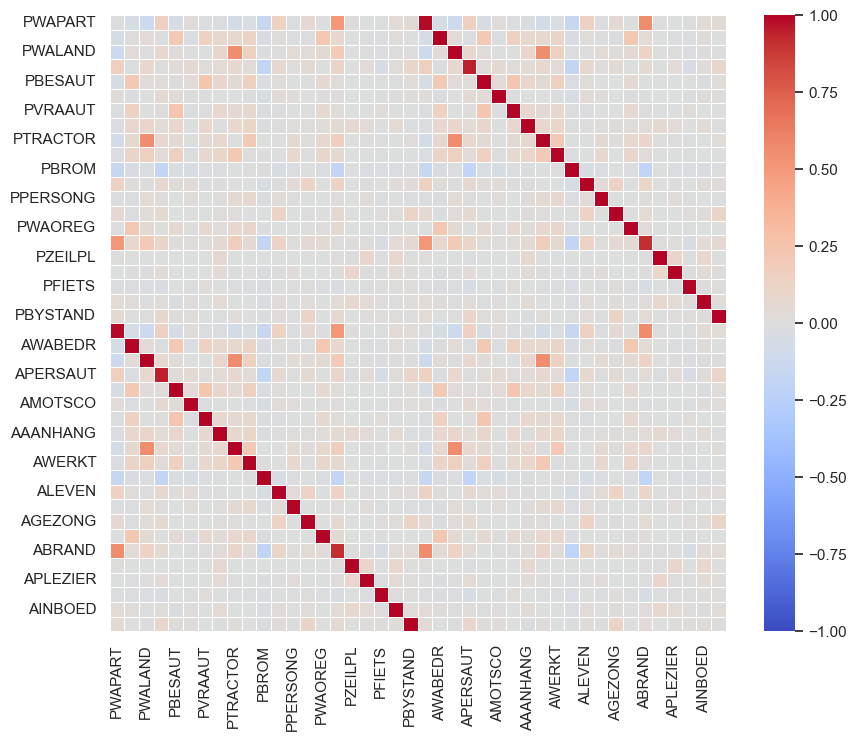

In [18]:
df_ticdata_variables_policies = df_ticdata[
    ["PWAPART", "PWABEDR", "PWALAND", "PPERSAUT", 
     "PBESAUT", "PMOTSCO", "PVRAAUT", "PAANHANG", 
     "PTRACTOR", "PWERKT", "PBROM", "PLEVEN", "PPERSONG",
     "PGEZONG", "PWAOREG","PBRAND", "PZEILPL", "PPLEZIER", 
     "PFIETS","PINBOED", "PBYSTAND","AWAPART","AWABEDR",
     "AWALAND","APERSAUT","ABESAUT","AMOTSCO","AVRAAUT",
     "AAANHANG","ATRACTOR","AWERKT","ABROM","ALEVEN",
     "APERSONG","AGEZONG","AWAOREG","ABRAND","AZEILPL",
     "APLEZIER","AFIETS", "AINBOED", "ABYSTAND"]]

get_corr_matrix(dataset = df_ticdata_variables_policies, size_figure = [10,8])

In [19]:
#comprobamos los resultados del grafico obteniendo la matriz de correlaciones. 

df_ticdata_variables_policies.corr(method = 'spearman')

PWAPART   PWABEDR   PWALAND  PPERSAUT   PBESAUT   PMOTSCO  \
PWAPART   1.000000 -0.047163 -0.111101  0.158245 -0.040925  0.023527   
PWABEDR  -0.047163  1.000000  0.033714 -0.011779  0.216533 -0.015888   
PWALAND  -0.111101  0.033714  1.000000  0.079374  0.026701 -0.004038   
PPERSAUT  0.158245 -0.011779  0.079374  1.000000  0.019013  0.057908   
PBESAUT  -0.040925  0.216533  0.026701  0.019013  1.000000  0.031521   
PMOTSCO   0.023527 -0.015888 -0.004038  0.057908  0.031521  1.000000   
PVRAAUT  -0.022796  0.144653 -0.005708  0.010823  0.238382 -0.007833   
PAANHANG -0.019500  0.085160  0.099282  0.045688  0.099526 -0.003964   
PTRACTOR -0.075141  0.075760  0.557020  0.080298  0.047395 -0.003073   
PWERKT   -0.024934  0.115155  0.152154  0.031518  0.153853 -0.011977   
PBROM    -0.153253 -0.032271 -0.010308 -0.176222 -0.024618 -0.043150   
PLEVEN    0.139312  0.019661  0.000528  0.070992  0.022324  0.036764   
PPERSONG -0.010215 -0.008745  0.039775  0.010389 -0.006671  0.022904   
PGEZONG   0.056989 -0.009688  0.018207  0.046971 -0.007390 -0.005177   
PWAOREG  -0.001413  0.224897  0.049273 -0.001973  0.054893  0.002173   
PBRAND    0.512962  0.081550  0.206860  0.113067  0.021854  0.010787   
PZEILPL   0.013126 -0.002714 -0.003294 -0.006312 -0.002070 -0.004520   
PPLEZIER -0.003985 -0.009024  0.004915  0.036191 -0.006884 -0.002718   
PFIETS   -0.011382 -0.019236 -0.015717 -0.036268 -0.002552 -0.014718   
PINBOED   0.042868  0.022890  0.001078  0.018230 -0.008047  0.013142   
PBYSTAND  0.047596 -0.001808  0.003103  0.091473  0.021293  0.022248   
AWAPART   0.989286 -0.049170 -0.111562  0.149409 -0.042272  0.019111   
AWABEDR  -0.047255  0.999970  0.033855 -0.011997  0.214862 -0.015964   
AWALAND  -0.111043  0.033807  0.999944  0.079418  0.026826 -0.003981   
APERSAUT  0.152571 -0.019640  0.084595  0.949831  0.018165  0.060993   
ABESAUT  -0.040878  0.216492  0.026700  0.019014  0.999994  0.031393   
AMOTSCO   0.023880 -0.016128 -0.003740  0.057821  0.031403  0.999814   
AVRAAUT  -0.022800  0.144678 -0.005708  0.010817  0.238391 -0.007833   
AAANHANG -0.019434  0.085141  0.099085  0.045691  0.099385 -0.003987   
ATRACTOR -0.075159  0.075443  0.557292  0.080241  0.047097 -0.003076   
AWERKT   -0.024928  0.115076  0.152128  0.031550  0.153848 -0.011977   
ABROM    -0.152564 -0.032286 -0.010112 -0.175535 -0.024629 -0.043110   
ALEVEN    0.140592  0.019100  0.000111  0.071357  0.022626  0.036714   
APERSONG -0.010157 -0.008745  0.039732  0.010432 -0.006671  0.022946   
AGEZONG   0.056973 -0.009688  0.018274  0.046916 -0.007390 -0.005153   
AWAOREG  -0.001384  0.224926  0.049310 -0.001959  0.054851  0.002163   
ABRAND    0.558860  0.046095  0.130971  0.047518 -0.005249 -0.012002   
AZEILPL   0.013123 -0.002714 -0.003294 -0.006317 -0.002070 -0.004520   
APLEZIER -0.004017 -0.009024  0.004987  0.036233 -0.006884 -0.002743   
AFIETS   -0.011138 -0.019235 -0.015763 -0.036053 -0.002627 -0.014679   
AINBOED   0.042850  0.022781  0.001140  0.018161 -0.008047  0.013159   
ABYSTAND  0.047635 -0.001887  0.002974  0.091598  0.021374  0.022319   

           PVRAAUT  PAANHANG  PTRACTOR    PWERKT     PBROM    PLEVEN  \
PWAPART  -0.022796 -0.019500 -0.075141 -0.024934 -0.153253  0.139312   
PWABEDR   0.144653  0.085160  0.075760  0.115155 -0.032271  0.019661   
PWALAND  -0.005708  0.099282  0.557020  0.152154 -0.010308  0.000528   
PPERSAUT  0.010823  0.045688  0.080298  0.031518 -0.176222  0.070992   
PBESAUT   0.238382  0.099526  0.047395  0.153853 -0.024618  0.022324   
PMOTSCO  -0.007833 -0.003964 -0.003073 -0.011977 -0.043150  0.036764   
PVRAAUT   1.000000  0.079573  0.051184  0.070785 -0.010624 -0.009054   
PAANHANG  0.079573  1.000000  0.078444  0.103235 -0.008929  0.004821   
PTRACTOR  0.051184  0.078444  1.000000  0.215082 -0.006995 -0.005496   
PWERKT    0.070785  0.103235  0.215082  1.000000  0.006295 -0.000076   
PBROM    -0.010624 -0.008929 -0.006995  0.006295  1.000000 -0.046376   
PLEVEN   -0.009054  0.004821 -0.005496 -0.000076 -

Cofirmamos con la matriz de los valores de correlación de Spearman que existe una correlacion practicamente perfecta entre una serie de variables. Estas son el último set de variables categoricas (de PWAPART a PBYSTAND) con el conjunto de variables numericas de esta misma dimensión (de AWAPART a ABYSTAND). Esto se debe a que mientras que las categoricas miran la contribución a diferentes seguros (PTRACTOR por ejemplo vemos en el diccionario que se lee como "Contribution tractor policies"), las numericas establecen el número de seguros (ATRACTOR se traduce como "Number of tractor policies").

Es por esto que a la hora de realizar un modelo podríamos prescidir de uno de estos dos conjuntos ya que representan lo mismo e incluso podrían alterar el modelo, dandole al doble de importancia a por ejemplo los seuros de bicicletas ya que existen dos variables que representan esto: PFIETS y AFIETS

3.4 SEPARAMOS LOS DATASETS DEPENDIENDO DEL TIPO DE VARIABLE (CATEGÓRICA, NUMÉRICA)

In [20]:
#VARIABLES CATEGÓRICAS

df_ticdata_varibales_categoricas = df_ticdata [
                        ["MOSTYPE", "MOSHOOFD", "MGODRK",
                        "MGODPR", "MGODOV", "MGODGE",
                        "MRELGE", "MRELSA", "MRELOV", "MFALLEEN",
                        "MFGEKIND", "MFWEKIND", "MOPLHOOG", "MOPLMIDD",
                        "MOPLLAAG", "MBERHOOG", "MBERZELF",
                        "MBERBOER", "MBERMIDD", "MBERARBG", "MBERARBO",
                        "MSKA","MSKB1", "MSKB2", "MSKC",
                        "MSKD", "MHHUUR", "MHKOOP", "MAUT1", "MAUT2",
                        "MAUT0", "MZFONDS", "MZPART", "MINKM30",
                        "MINK3045", "MINK4575", "MINK7512", "MINK123M",
                        "MINKGEM", "MKOOPKLA", "PWAPART", "PWABEDR", "PWALAND",
                        "PPERSAUT", "PBESAUT", "PMOTSCO", "PVRAAUT",
                        "PAANHANG", "PTRACTOR", "PWERKT", "PBROM",
                        "PLEVEN", "PPERSONG", "PGEZONG", "PWAOREG",
                        "PBRAND", "PZEILPL", "PPLEZIER", "PFIETS","PINBOED",
                        "PBYSTAND","CARAVAN"]]

df_ticdata_varibales_categoricas.head()

MOSTYPE  MOSHOOFD  MGODRK  MGODPR  MGODOV  MGODGE  MRELGE  MRELSA  MRELOV  \
0       33         8       0       5       1       3       7       0       2   
1       37         8       1       4       1       4       6       2       2   
2       37         8       0       4       2       4       3       2       4   
3        9         3       2       3       2       4       5       2       2   
4       40        10       1       4       1       4       7       1       2   

   MFALLEEN  MFGEKIND  MFWEKIND  MOPLHOOG  MOPLMIDD  MOPLLAAG  MBERHOOG  \
0         1         2         6         1         2         7         1   
1         0         4         5         0         5         4         0   
2         4         4         2         0         5         4         0   
3         2         3         4         3         4         2         4   
4         2         4         4         5         4         0         0   

   MBERZELF  MBERBOER  MBERMIDD  MBERARBG  MBERARBO  MSKA  MSKB1  MSKB2  MSKC  \
0         0         1         2         5         2     1      1      2     6   
1         0         0         5         0         4     0      2      3     5   
2         0         0         7         0         2     0      5      0     4   
3         0         0         3         1         2     3      2      1     4   
4         5         4         0         0         0     9      0      0     0   

   MSKD  MHHUUR  MHKOOP  MAUT1  MAUT2  MAUT0  MZFONDS  MZPART  MINKM30  \
0     1       1       8      8      0      1        8       1        0   
1     0       2       7      7      1      2        6       3        2   
2     0       7       2      7      0      2        9       0        4   
3     0       5       4      9      0      0        7       2        1   
4     0       4       5      6      2      1        5       4        0   

   MINK3045  MINK4575  MINK7512  MINK123M  MINKGEM  MKOOPKLA  PWAPART  \
0         4         5         0         0        4         3        0   
1         0         5         2         0        5         4        2   
2         5         0         0         0        3         4        2   
3         5         3         0         0        4         4        0   
4         0         9         0         0        6         3        0   

   PWABEDR  PWALAND  PPERSAUT  PBESAUT  PMOTSCO  PVRAAUT  PAANHANG  PTRACTOR  \
0        0        0         6        0        0        0         0         0   
1        0        0         0        0        0        0         0         0   
2        0        0         6        0        0        0         0         0   
3        0        0         6        0        0        0         0         0   
4        0        0         0        0        0        0         0         0   

   PWERKT  PBROM  PLEVEN  PPERSONG  PGEZONG  PWAOREG  PBRAND  PZEILPL  \
0       0      0       0         0        0        0       5        0   
1       0      0       0         0        0        0       2        0   
2       0      0       0         0        0        0       2        0   
3       0      0       0         0        0        0       2        0   
4       0      0       0         0        0        0       6        0   

   PPLEZIER  PFIETS  PINBOED  PBYSTAND  CARAVAN  
0         0       0        0         0        0  
1         0       0        0         0        0  
2         0       0        0         0        0  
3         0       0        0         0        0  
4         0       0        0         0        0

In [21]:
#VARIABLES NUMÉRICAS

df_ticdata_variables_numericas = df_ticdata[
                            ["MAANTHUI", "MGEMOMV", "MGEMLEEF",
                            "AWAPART","AWABEDR", "AWALAND","APERSAUT",
                            "ABESAUT","AMOTSCO", "AVRAAUT","AAANHANG",
                            "ATRACTOR","AWERKT","ABROM","ALEVEN",
                            "APERSONG","AGEZONG","AWAOREG","ABRAND",
                            "AZEILPL","APLEZIER", "AFIETS", "AINBOED",
                            "ABYSTAND", "CARAVAN"]]
df_ticdata_variables_numericas.head()

MAANTHUI  MGEMOMV  MGEMLEEF  AWAPART  AWABEDR  AWALAND  APERSAUT  ABESAUT  \
0         1        3        35        0        0        0         1        0   
1         1        2        35        2        0        0         0        0   
2         1        2        35        1        0        0         1        0   
3         1        3        45        0        0        0         1        0   
4         1        4        35        0        0        0         0        0   

   AMOTSCO  AVRAAUT  AAANHANG  ATRACTOR  AWERKT  ABROM  ALEVEN  APERSONG  \
0        0        0         0         0       0      0       0         0   
1        0        0         0         0       0      0       0         0   
2        0        0         0         0       0      0       0         0   
3        0        0         0         0       0      0       0         0   
4        0        0         0         0       0      0       0         0   

   AGEZONG  AWAOREG  ABRAND  AZEILPL  APLEZIER  AFIETS  AINBOED  ABYSTAND  \
0        0        0       1        0         0       0        0         0   
1        0        0       1        0         0       0        0         0   
2        0        0       1        0         0       0        0         0   
3        0        0       1        0         0       0        0         0   
4        0        0       1        0         0       0        0         0   

   CARAVAN  
0        0  
1        0  
2        0  
3        0  
4        0

# 3.4.1 ESTUDIO VARIABLES CATEGORICAS DEL DF TRAIN

Utilizamos v de cramer para observar variables categoricas que consideramos que estan altamente correladas, basandonos en la descriocion de las mismas del diccionario. Esta función está definida en functions.py

In [22]:
rows = []

for var1 in df_ticdata_varibales_categoricas:
  col = []
  for var2 in df_ticdata_varibales_categoricas :
    cramers = cramers_v(df_ticdata_varibales_categoricas[var1], df_ticdata_varibales_categoricas[var2]) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
df_vcramer = pd.DataFrame(cramers_results, columns = df_ticdata_varibales_categoricas.columns,
                          index = df_ticdata_varibales_categoricas.columns)



df_vcramer

MOSTYPE  MOSHOOFD  MGODRK  MGODPR  MGODOV  MGODGE  MRELGE  MRELSA  \
MOSTYPE      1.00      1.00    0.16    0.19    0.21    0.19    0.28    0.20   
MOSHOOFD     1.00      1.00    0.09    0.11    0.12    0.10    0.21    0.14   
MGODRK       0.16      0.09    1.00    0.22    0.17    0.12    0.10    0.17   
MGODPR       0.19      0.11    0.22    1.00    0.25    0.43    0.14    0.17   
MGODOV       0.21      0.12    0.17    0.25    1.00    0.16    0.18    0.24   
MGODGE       0.19      0.10    0.12    0.43    0.16    1.00    0.14    0.16   
MRELGE       0.28      0.21    0.10    0.14    0.18    0.14    1.00    0.31   
MRELSA       0.20      0.14    0.17    0.17    0.24    0.16    0.31    1.00   
MRELOV       0.29      0.20    0.10    0.13    0.20    0.14    0.61    0.16   
MFALLEEN     0.28      0.20    0.07    0.10    0.14    0.09    0.35    0.13   
MFGEKIND     0.18      0.11    0.07    0.11    0.13    0.12    0.12    0.14   
MFWEKIND     0.27      0.20    0.08    0.11    0.14    0.11    0.25    0.12   
MOPLHOOG     0.29      0.21    0.12    0.11    0.12    0.09    0.12    0.09   
MOPLMIDD     0.22      0.15    0.09    0.11    0.12    0.10    0.12    0.10   
MOPLLAAG     0.30      0.22    0.11    0.11    0.10    0.10    0.14    0.09   
MBERHOOG     0.26      0.18    0.12    0.13    0.15    0.13    0.12    0.12   
MBERZELF     0.30      0.12    0.16    0.14    0.12    0.14    0.10    0.14   
MBERBOER     0.33      0.22    0.06    0.11    0.20    0.10    0.11    0.09   
MBERMIDD     0.21      0.13    0.09    0.13    0.13    0.11    0.11    0.12   
MBERARBG     0.23      0.16    0.09    0.12    0.15    0.11    0.12    0.11   
MBERARBO     0.23      0.17    0.08    0.12    0.13    0.10    0.17    0.12   
MSKA         0.27      0.19    0.10    0.11    0.15    0.10    0.11    0.11   
MSKB1        0.18      0.12    0.09    0.09    0.12    0.08    0.12    0.12   
MSKB2        0.21      0.13    0.08    0.12    0.13    0.10    0.10    0.10   
MSKC         0.25      0.19    0.10    0.11    0.11    0.10    0.11    0.10   
MSKD         0.22      0.15    0.07    0.12    0.13    0.11    0.16    0.11   
MHHUUR       0.29      0.21    0.09    0.14    0.16    0.14    0.20    0.15   
MHKOOP       0.29      0.21    0.09    0.14    0.16    0.14    0.20    0.14   
MAUT1        0.24      0.15    0.13    0.15    0.16    0.12    0.24    0.13   
MAUT2        0.24      0.14    0.14    0.16    0.14    0.11    0.16    0.14   
MAUT0        0.28      0.18    0.12    0.15    0.20    0.13    0.31    0.16   
MZFONDS      0.26      0.19    0.14    0.12    0.16    0.14    0.18    0.17   
MZPART       0.26      0.19    0.14    0.12    0.16    0.14    0.18    0.17   
MINKM30      0.23      0.17    0.10    0.12    0.11    0.12    0.21    0.10   
MINK3045     0.21      0.13    0.08    0.10    0.12    0.09    0.12    0.09   
MINK4575     0.25      0.18    0.08    0.11    0.15    0.11    0.15    0.11   
MINK7512     0.16      0.10    0.14    0.08    0.08    0.04    0.10    0.09   
MINK123M     0.14      0.08    0.13    0.08    0.09    0.09    0.07    0.07   
MINKGEM      0.26      0.20    0.13    0.12    0.10    0.11    0.19    0.08   
MKOOPKLA     0.95      0.61    0.10    0.10    0.09    0.09    0.17    0.08   
PWAPART      0.09      0.07    0.02    0.00    0.02    0.00    0.04    0.00   
PWABEDR      0.02      0.02    0.00    0.00    0.00    0.00    0.00    0.00   
PWALAND      0.10      0.11    0.01    0.04    0.02    0.03    0.02    0.00   
PPERSAUT     0.04      0.05    0.00    0.06    0.01    0.01    0.02    0.00   
PBESAUT      0.05      0.00    0.00    0.00    0.00    0.00    0.00    0.00   
PMOTSCO      0.05      0.03    0.00    0.00    0.00    0.00    0.03    0.00   
PVRAAUT      0.00      0.01    0.00    0.00    0.00    0.00    0.00    0.00   
PAANHANG     0.07      0.04    0.00    0.00    0.00    0.00    0.00    0.00   
PTRACTOR     0.12      0.13    0.00    0.02    0.04    0.01    0.02    0.00   
PWERKT       0.08      0.07    0.00    0.03    0.02    0.00 

<AxesSubplot:>

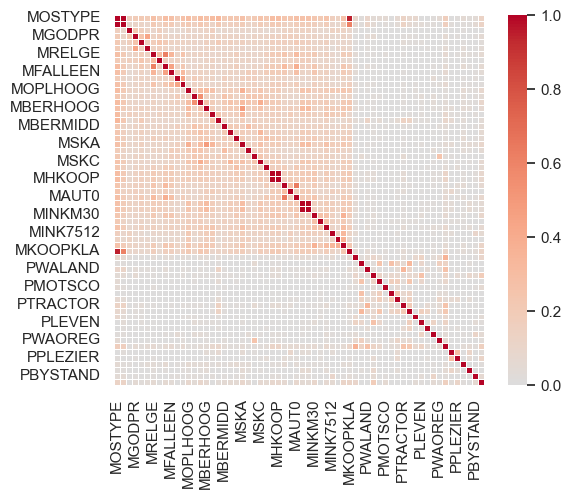

In [23]:
sns.heatmap(df_vcramer, vmin=0, vmax=1,center = 0, square = True, linewidths = .5, cmap = 'coolwarm')

Observamos que tan solo existen algunas variables con correlación significativa. Procemos a revisarlas, gracias al diccionario y al dataset:

In [24]:
#Customer Subtype  vs Customer main type

cramers_v(df_ticdata_varibales_categoricas["MOSTYPE"],
          df_ticdata_varibales_categoricas["MOSHOOFD"])

0.9974157937677048

In [25]:
#Customer Subtype  vs Purchasing power class

cramers_v(df_ticdata_varibales_categoricas["MOSTYPE"],
          df_ticdata_varibales_categoricas["MKOOPKLA"])

0.953719608831212

In [26]:
#Home owners vs Rented house 

cramers_v(df_ticdata_varibales_categoricas["MHKOOP"],
          df_ticdata_varibales_categoricas["MHHUUR"])

0.9899162769547202

In [27]:
#National Health Service vs Private health insurance  

cramers_v(df_ticdata_varibales_categoricas["MZFONDS"],
          df_ticdata_varibales_categoricas["MZPART"])

0.9947960599531752

In [28]:
#Average income  vs Purchasing power class

cramers_v(df_ticdata_varibales_categoricas["MINKGEM"],
          df_ticdata_varibales_categoricas["MKOOPKLA"])

0.22021007250782393

In [29]:
# High level of education vs income > 123.000

cramers_v(df_ticdata_varibales_categoricas["MOPLHOOG"],
          df_ticdata_varibales_categoricas["MINK123M"])

0.1991300006594408

In [30]:
# Household with children vs Average income

cramers_v(df_ticdata_varibales_categoricas["MFWEKIND"],
          df_ticdata_varibales_categoricas["MINKGEM"])

0.12960106539713348

Tras comprobar varias variables que entendiamos podrían altamente correladas, observamos:

- Customer subtype y Customer main type estan altamente correlacionadas ya que representan lo mismo.
- Customer Subtype y Purchasing power class estan altamente correlacionadas ya que representan lo mismo.
- Home owners y Rented house están altamente correlacionadas, pero son contrarias. 
- National Health Service y Private health insurance están altamente correlacionadas, pero son contrarias. 

# 3.4.1 ESTUDIO VARIABLES NUMÉRICAS DEL DF TRAIN

Realizamos una heatmap de la matriz de correlación de las variables numericas del dataset, utilizando Pearson

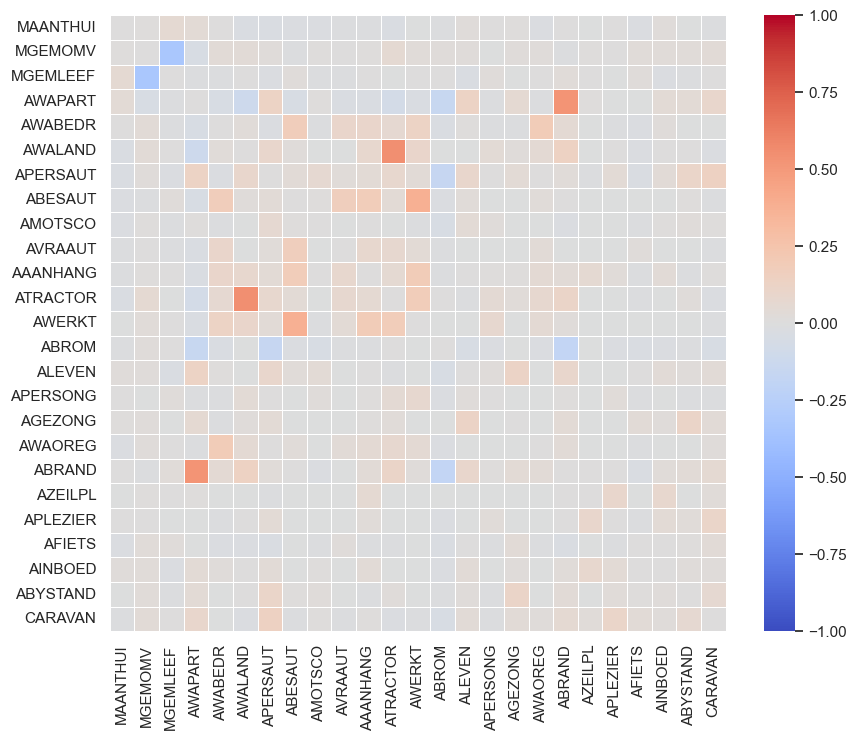

In [31]:
get_corr_matrix(dataset = df_ticdata_variables_numericas ,
                metodo = 'pearson', size_figure = [10,8])

Observamos que no hay ninguna correlación significativa, siendo la máxima correlación de 0.5

# 3.5 ESTUDIO DE LOS HISTOGRAMAS DE LAS VARIABLES VS LA VARIABLE OBJETIVO (CARAVAN)

Realizamos los histogramas para comprobar la densidad de todas las variables y los histogramas que nos identifican la proporcion entre los resultados Caravan y los posibles datos de las diferentes variables

In [32]:
def plot_feature(df, col_name, isContinuous, target):
    """
    Visualize a variable with and without faceting on the loan status.
    - df dataframe
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12,3), dpi = 90)
    
    count_null = df[col_name].isnull().sum()
    if isContinuous:
        
        sns.histplot(df.loc[df[col_name].notnull(), col_name], kde = False, ax = ax1)
    else:
        sns.countplot(df[col_name], order=sorted(df[col_name].unique()),
                      color = '#5975A4', saturation = 1, ax = ax1)
    ax1.set_xlabel(col_name)
    ax1.set_ylabel('Count')
    ax1.set_title(col_name+ ' Numero de nulos: ' + str(count_null))
    plt.xticks(rotation = 90)


    if isContinuous:
        sns.boxplot(x = col_name, y = target, data = df, ax = ax2)
        ax2.set_ylabel('')
        ax2.set_title(col_name + ' by '+ target)
    else:
        data = df.groupby(col_name)[target].value_counts(normalize=True).to_frame('proportion').reset_index() 
        data.columns = [i, target, 'proportion']
        sns.barplot(x = col_name, y = 'proportion', hue = target, data = data, saturation = 1, ax = ax2)
        ax2.set_ylabel(target + ' fraction')
        ax2.set_title(target)
        plt.xticks(rotation = 90)
    ax2.set_xlabel(col_name)
    
    plt.tight_layout()

La función guardada en functions.py da error a la hora de ejecutar el bucle de abajo, por tanto la volvemos a definir

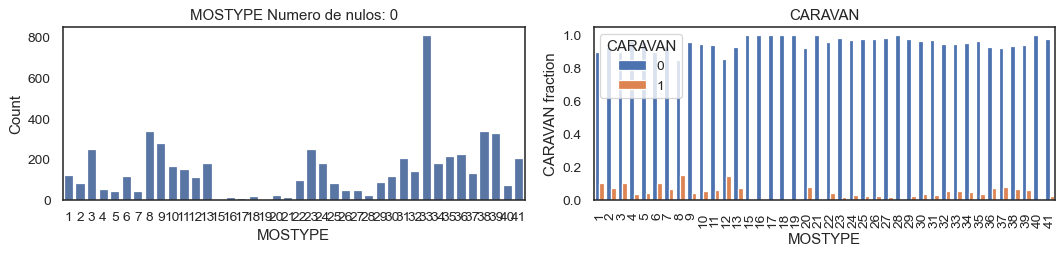

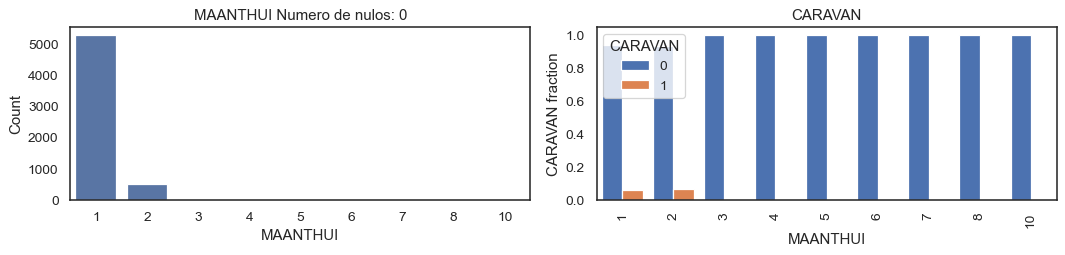

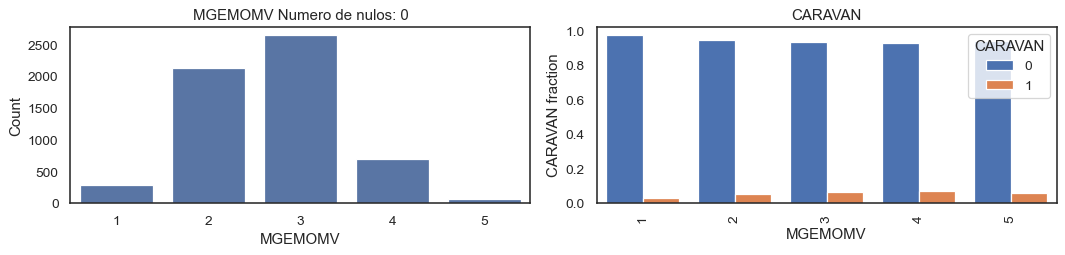

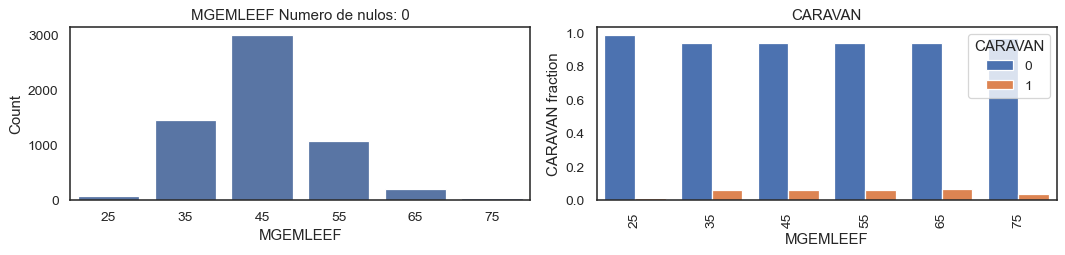

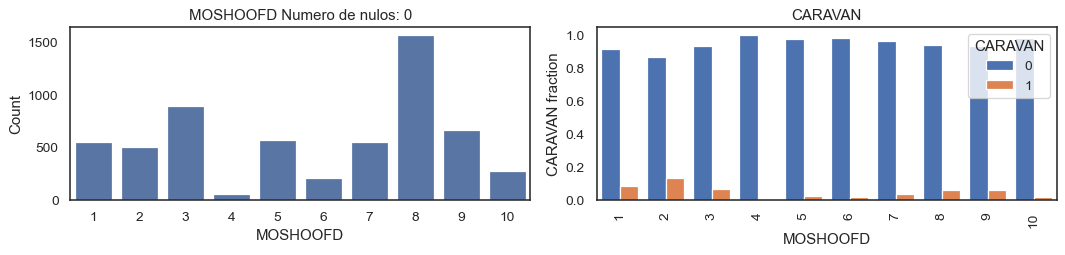

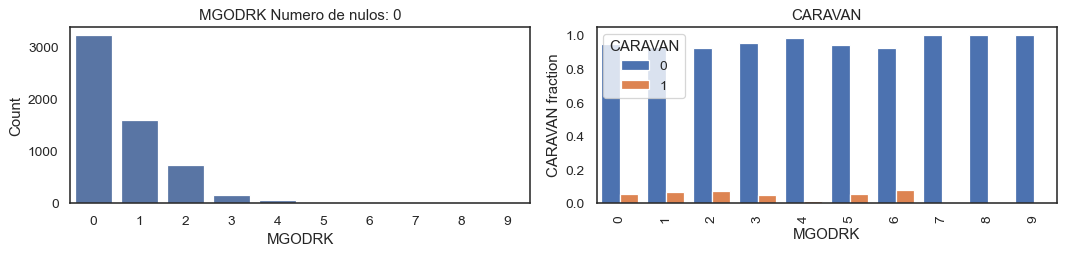

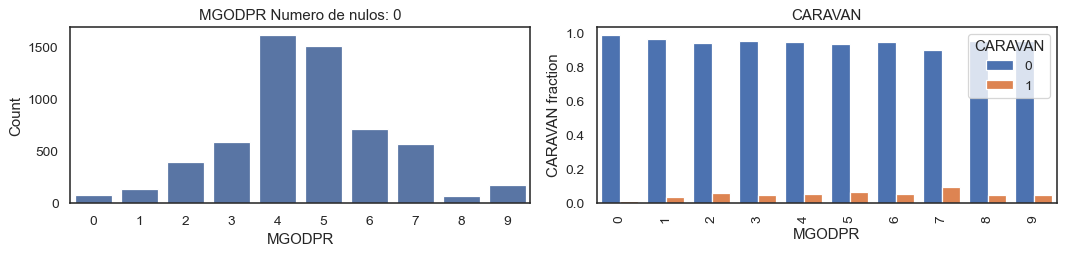

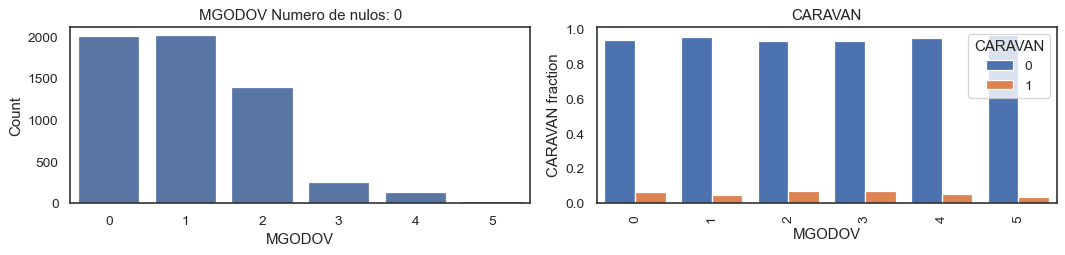

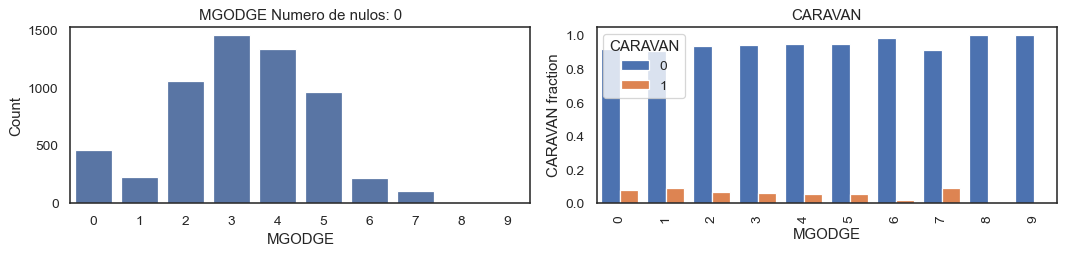

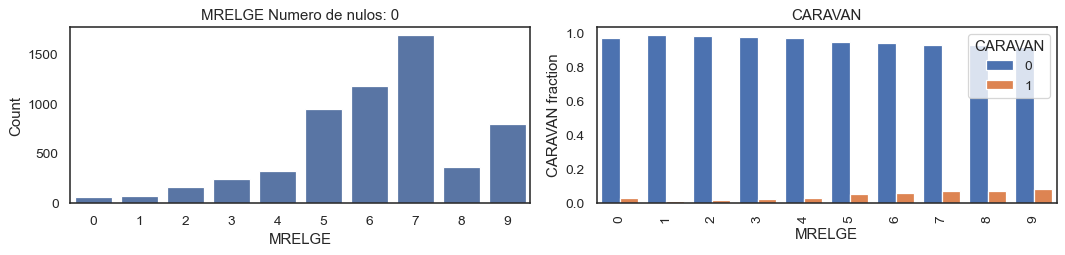

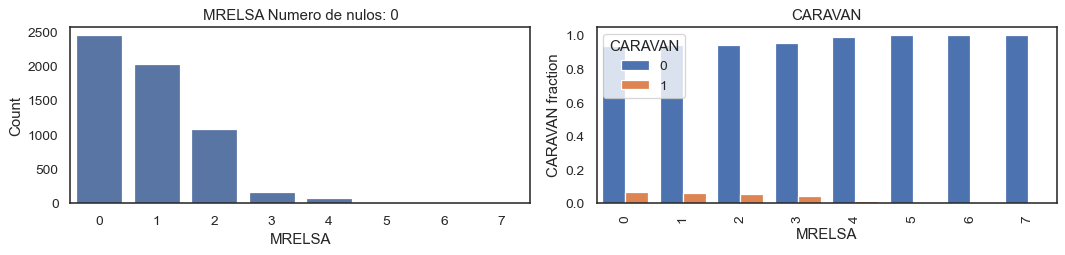

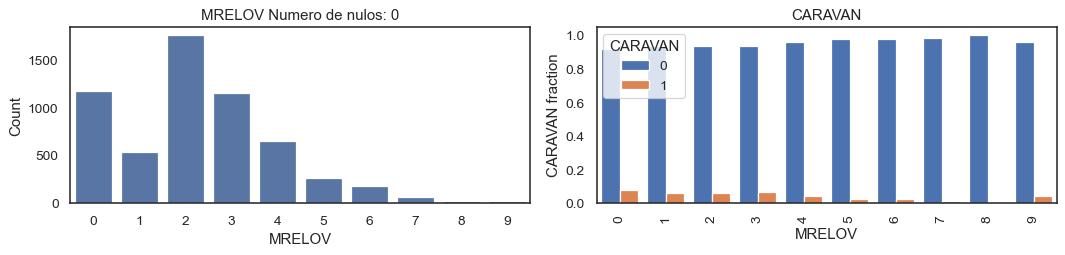

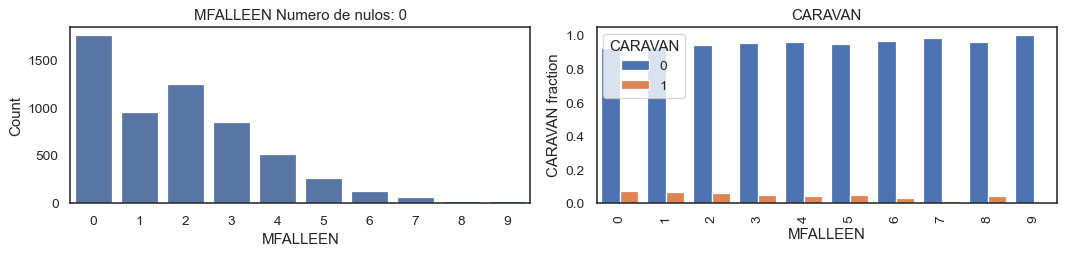

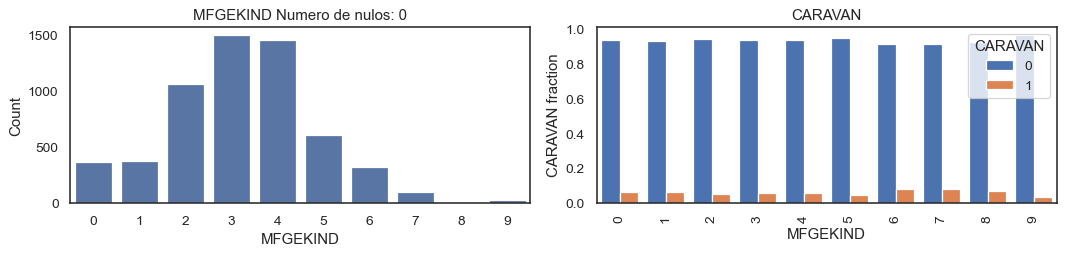

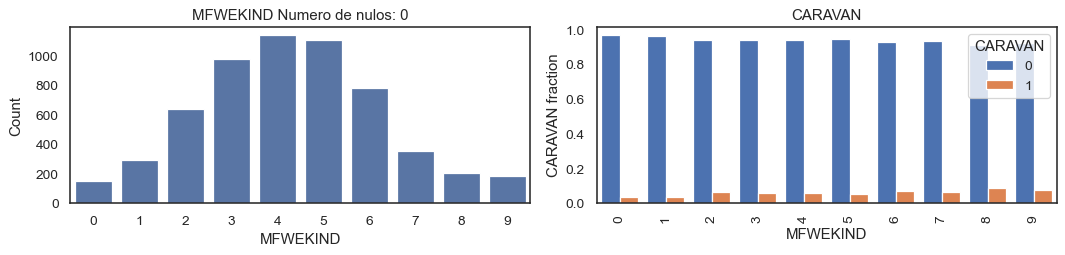

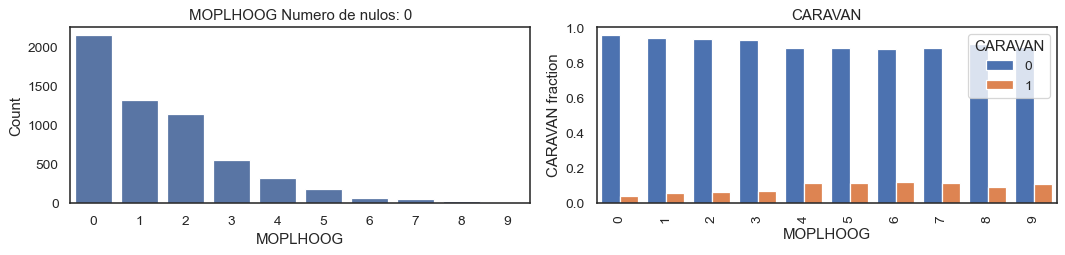

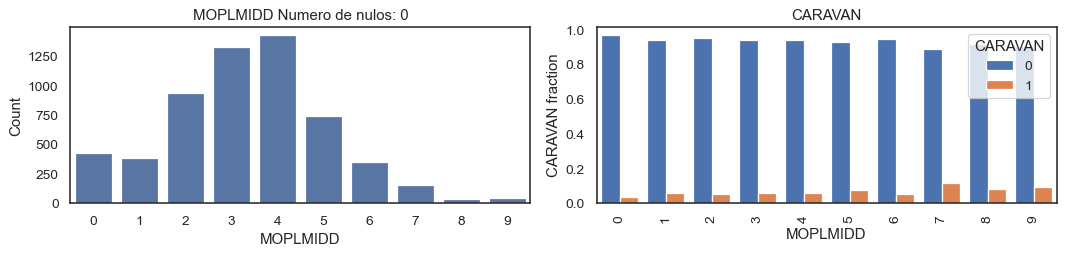

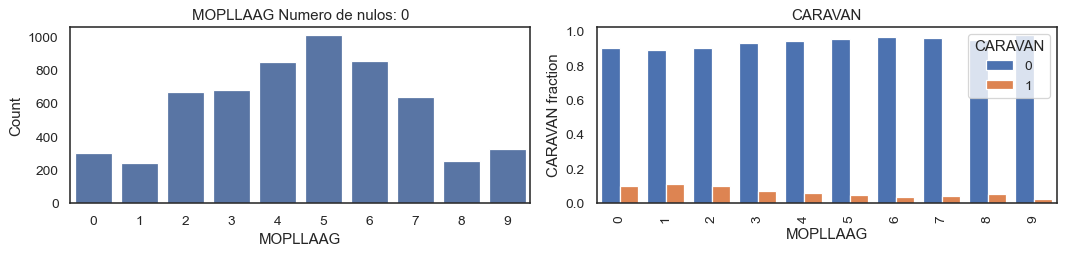

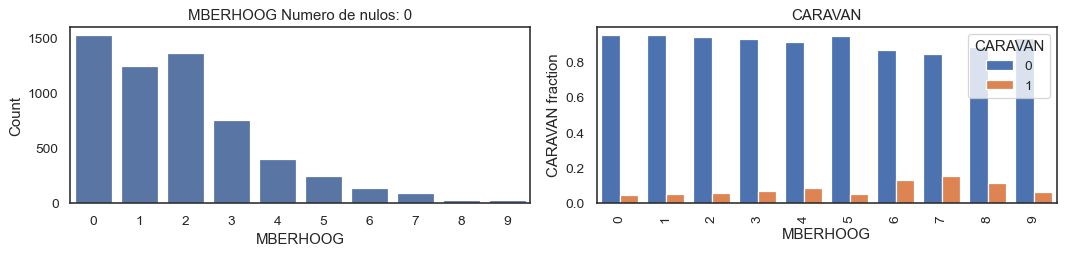

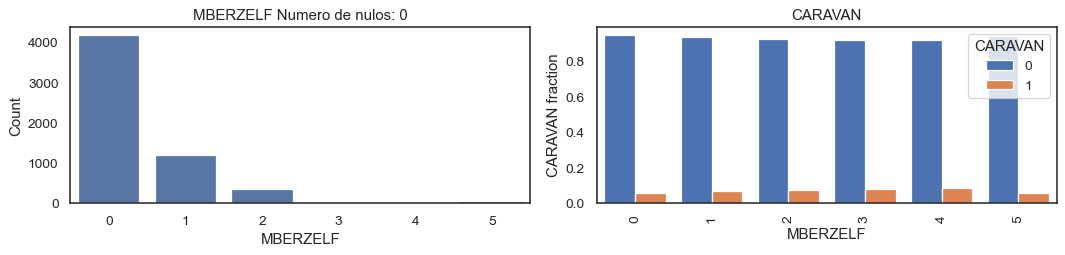

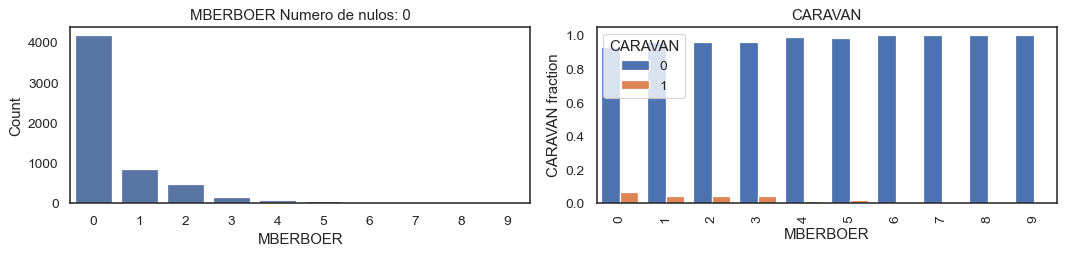

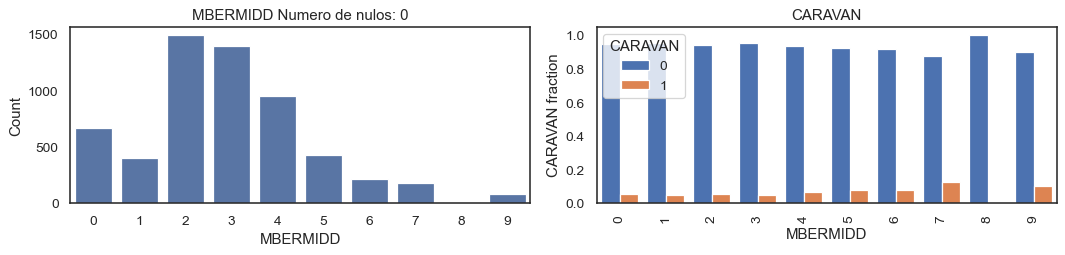

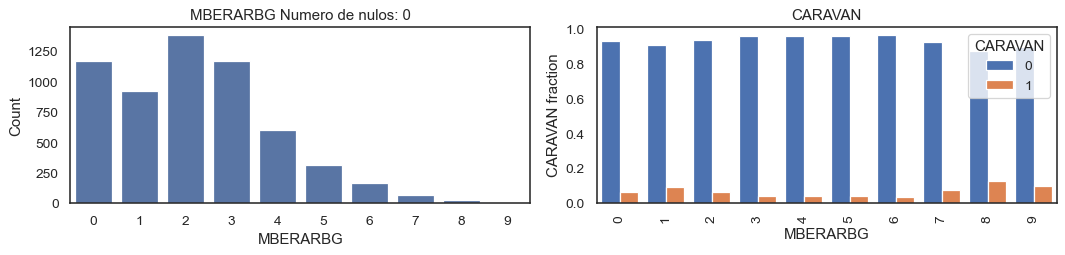

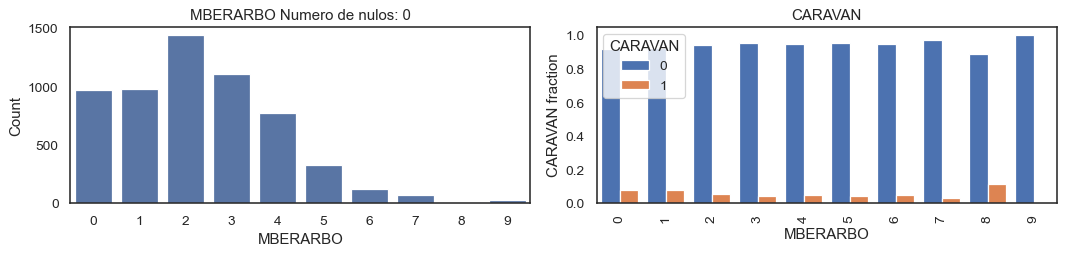

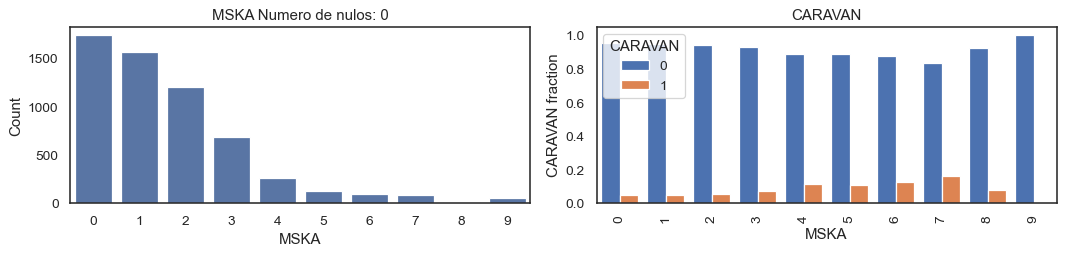

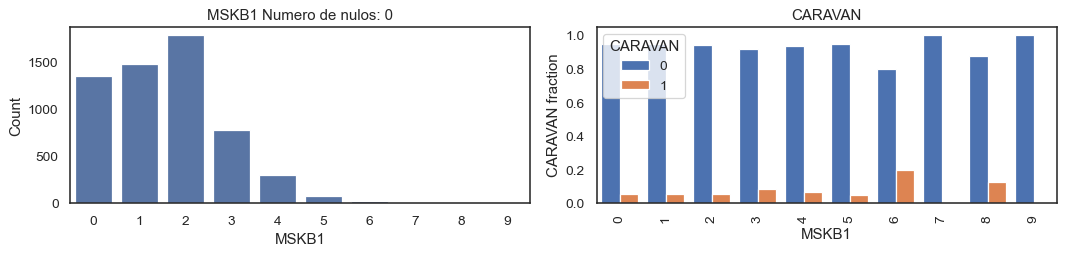

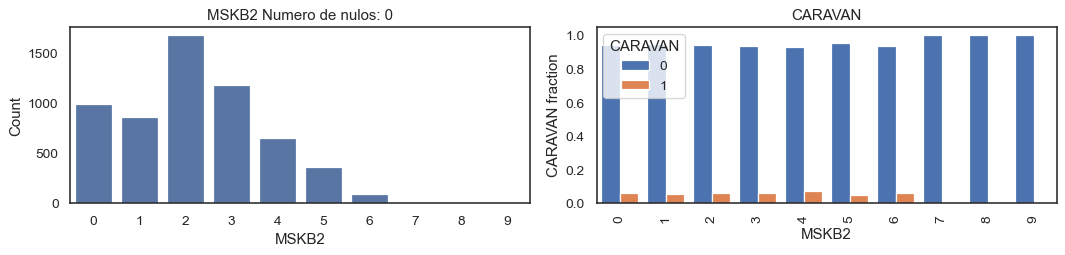

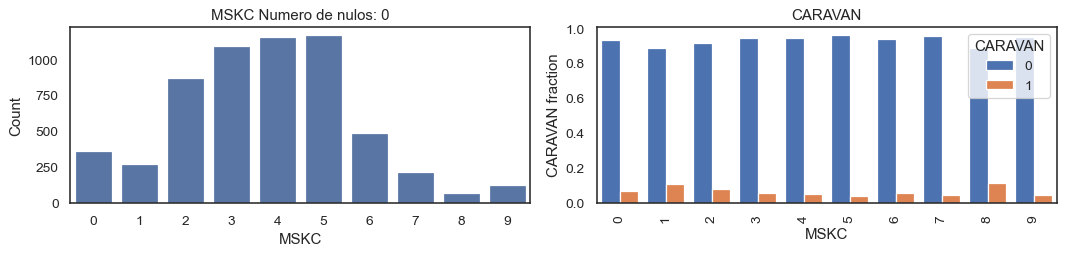

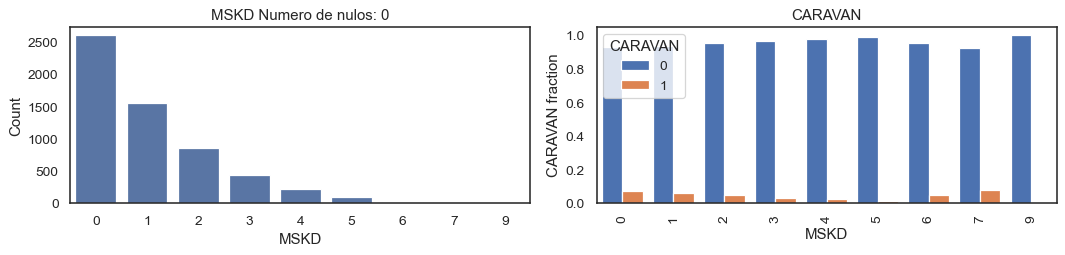

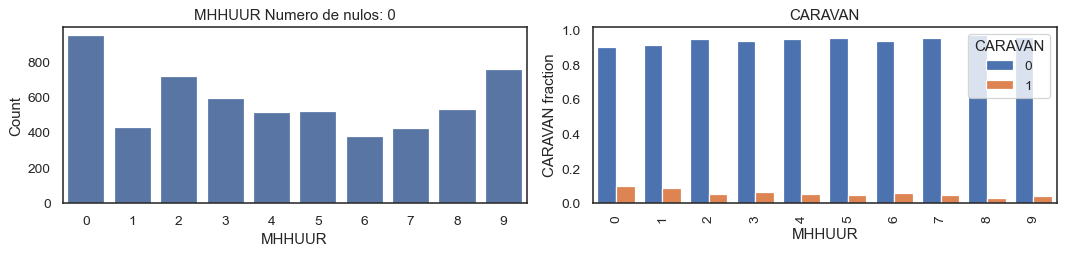

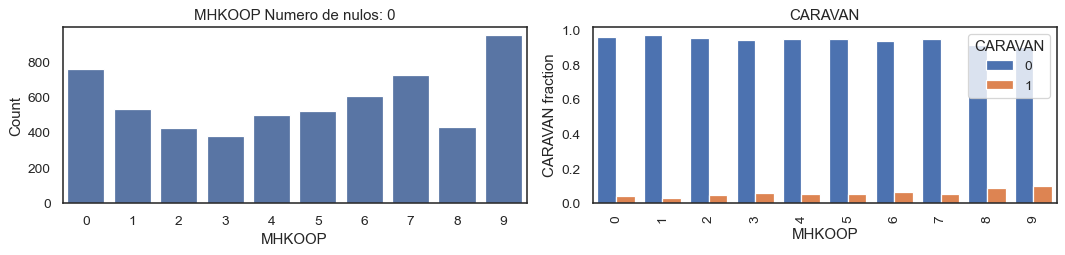

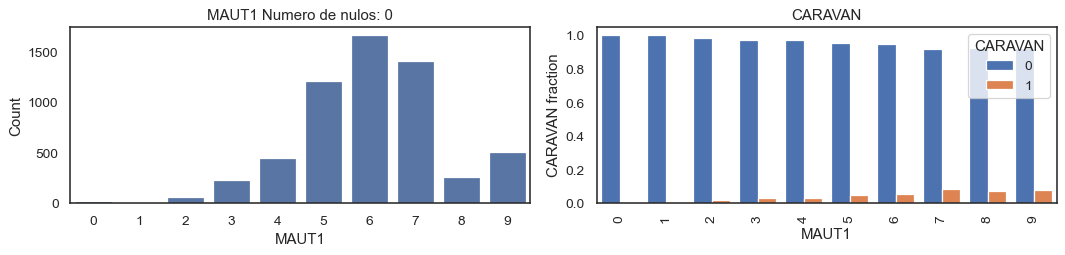

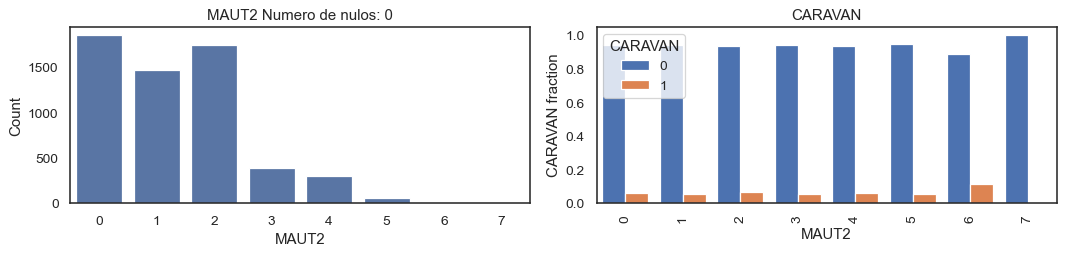

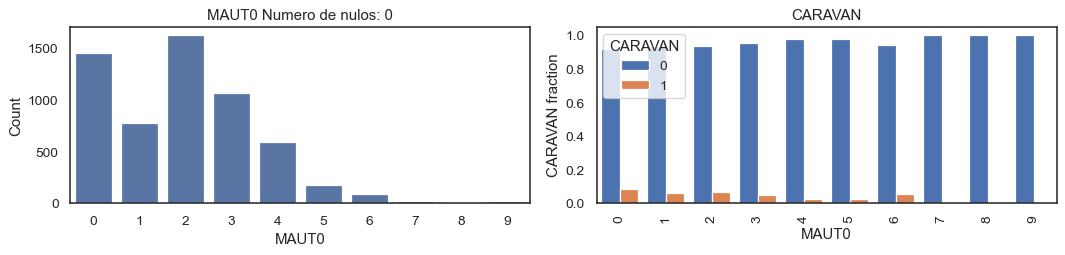

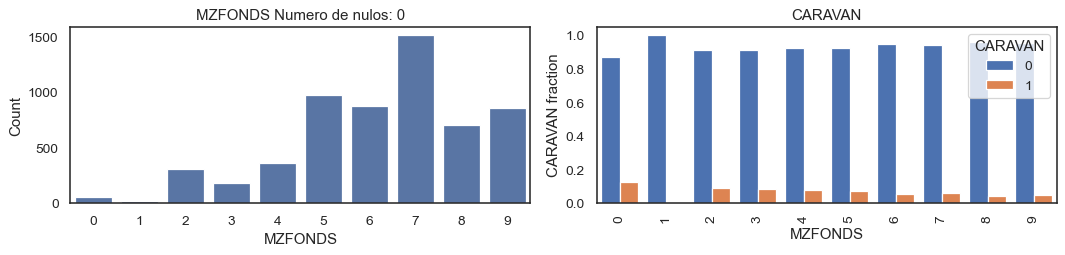

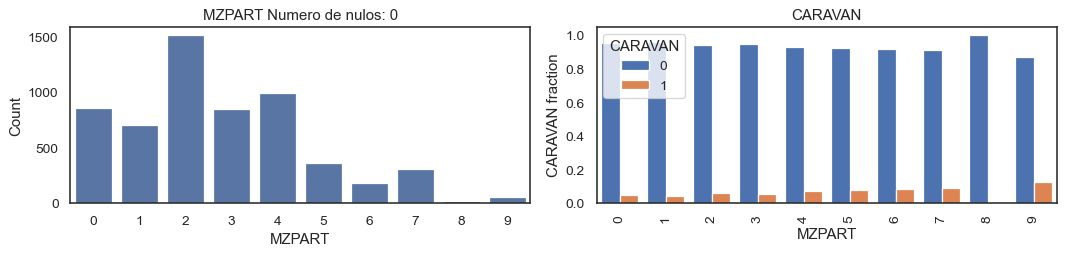

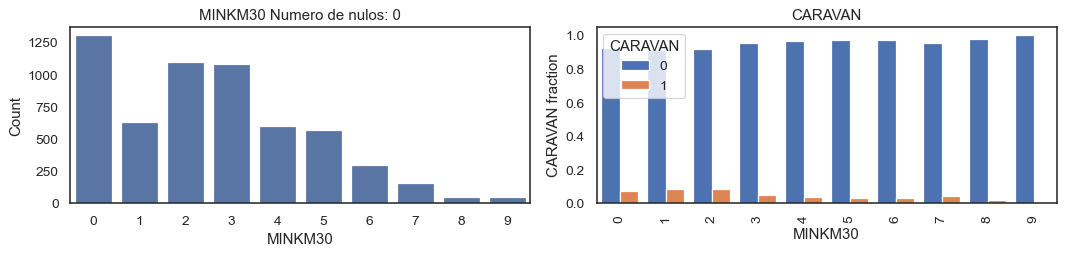

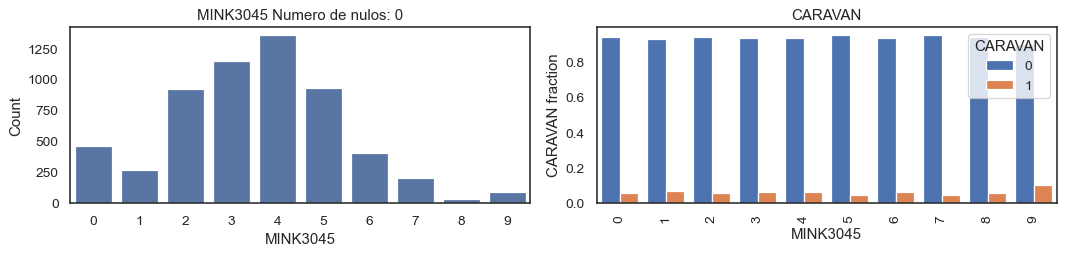

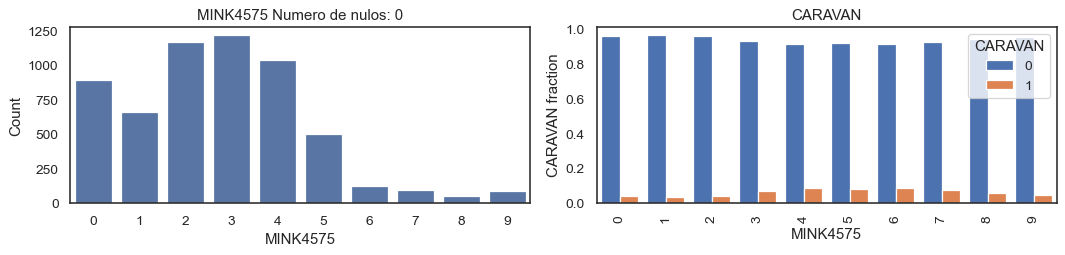

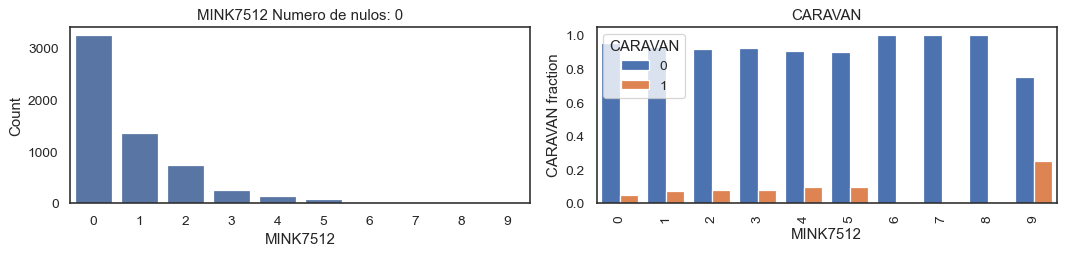

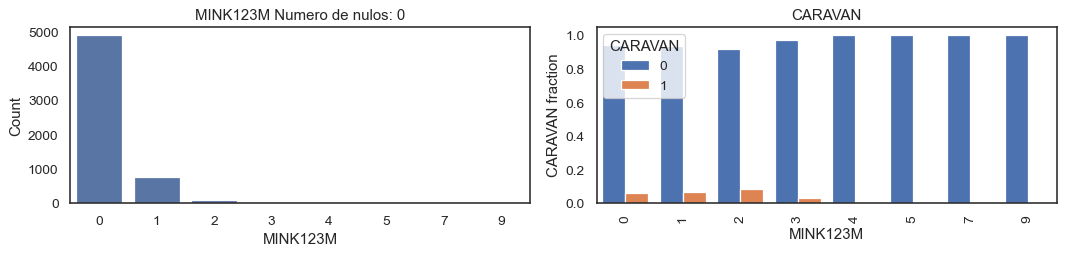

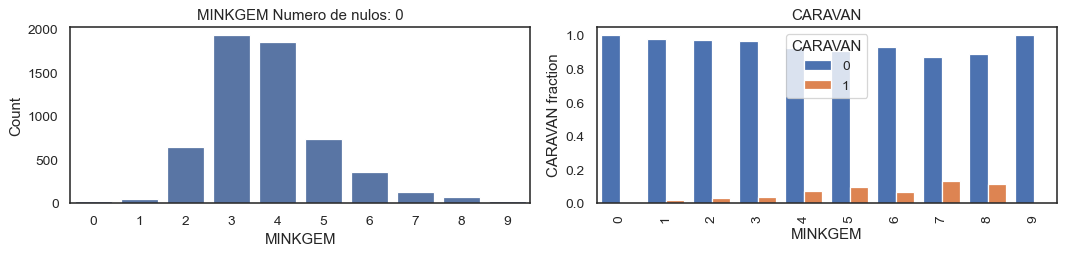

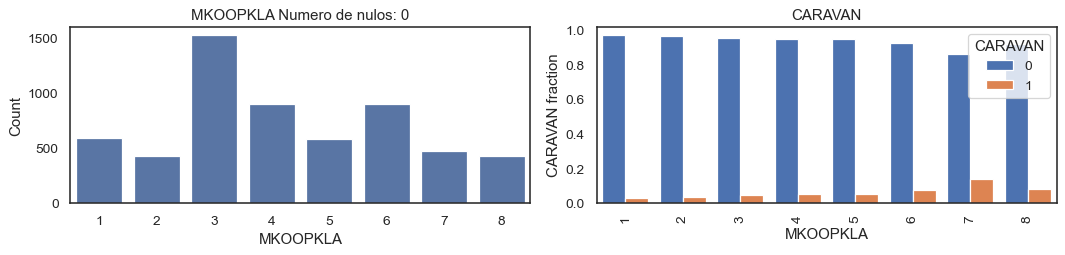

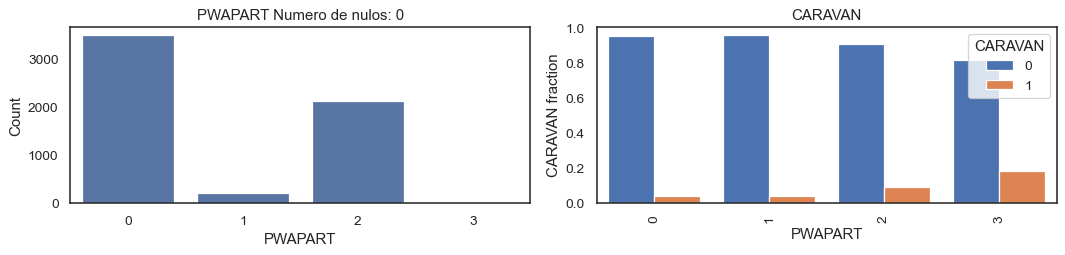

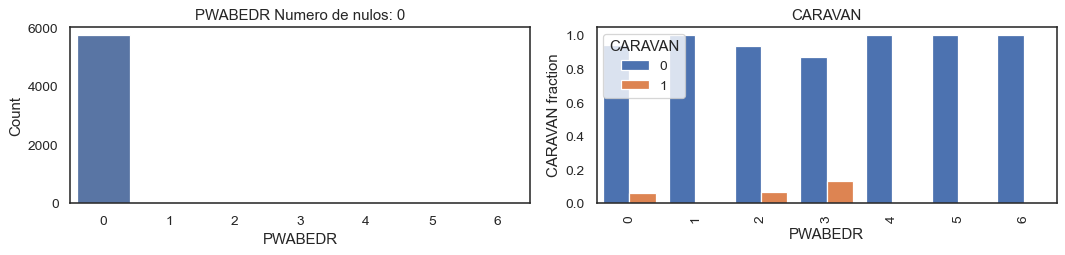

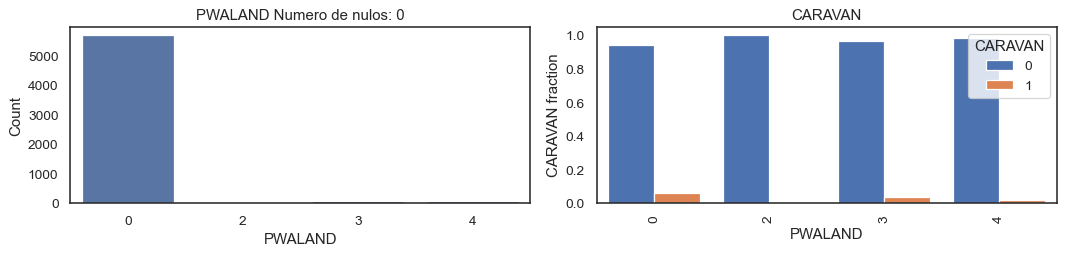

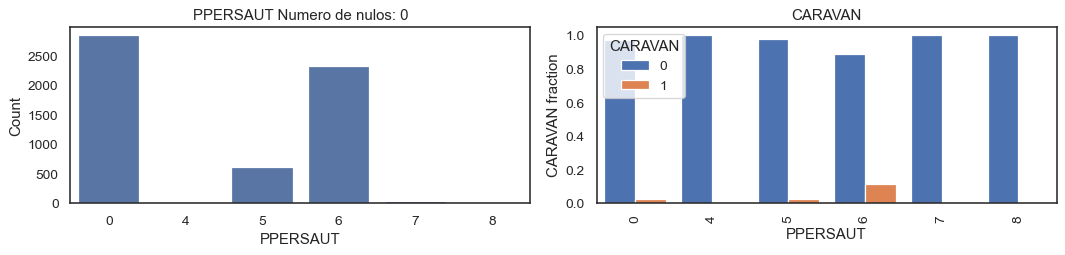

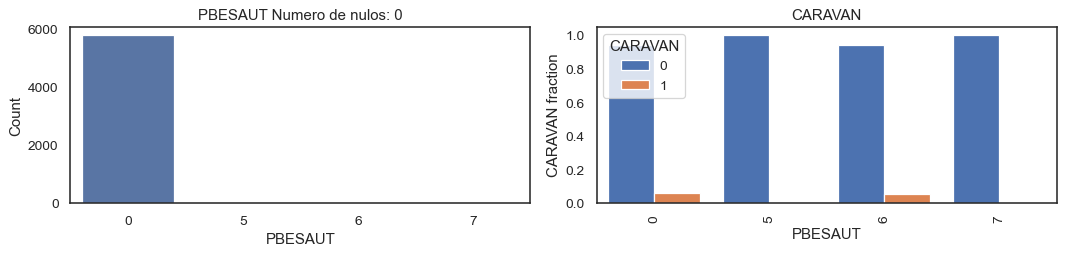

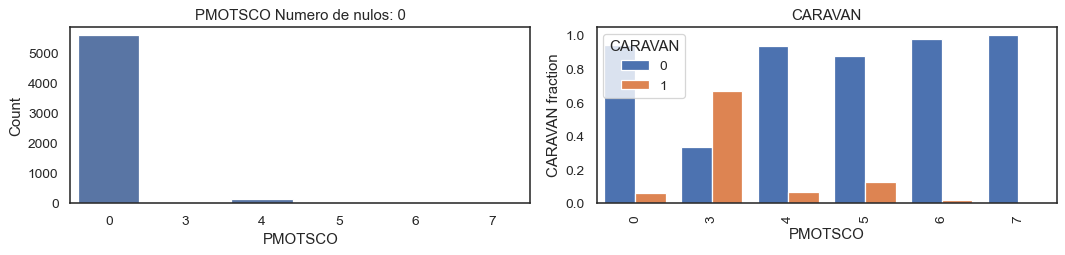

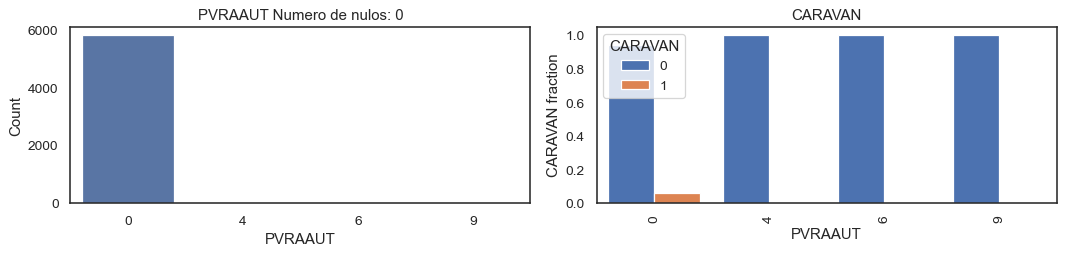

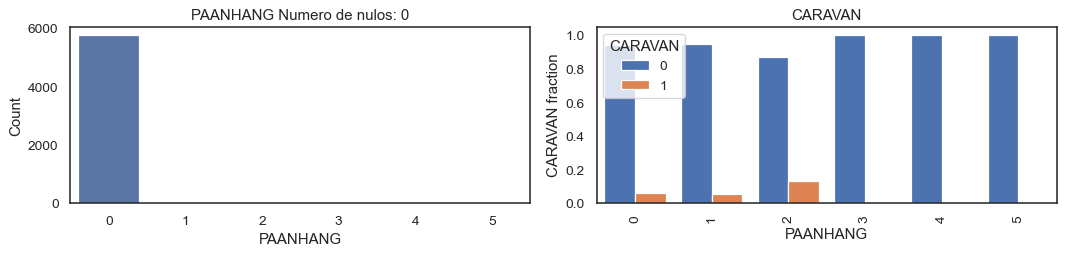

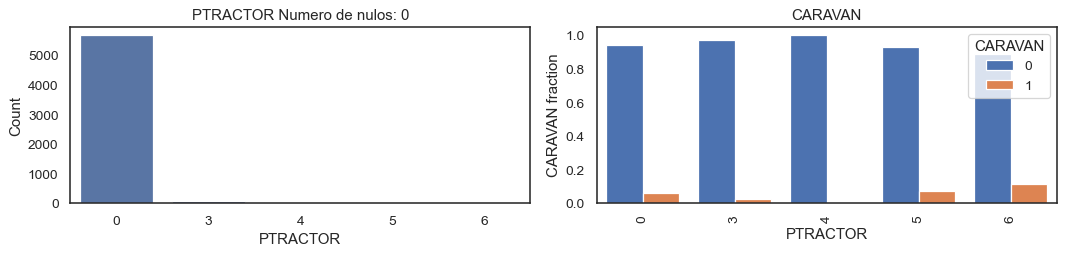

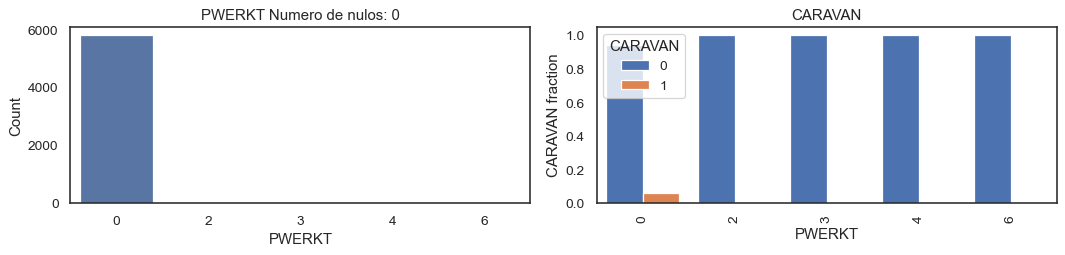

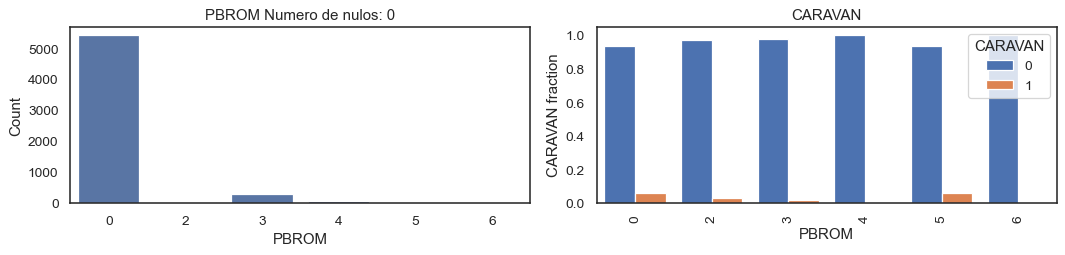

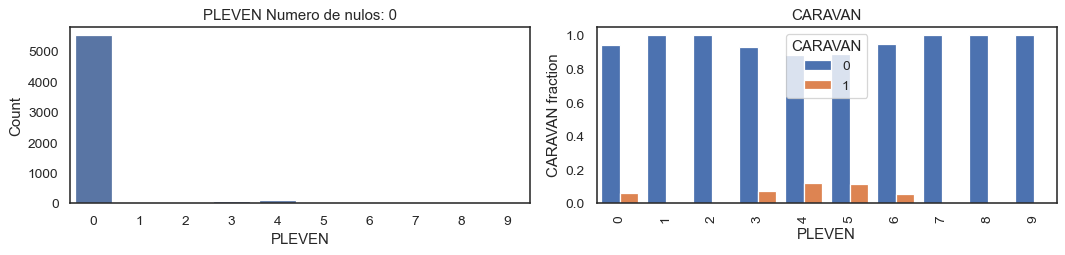

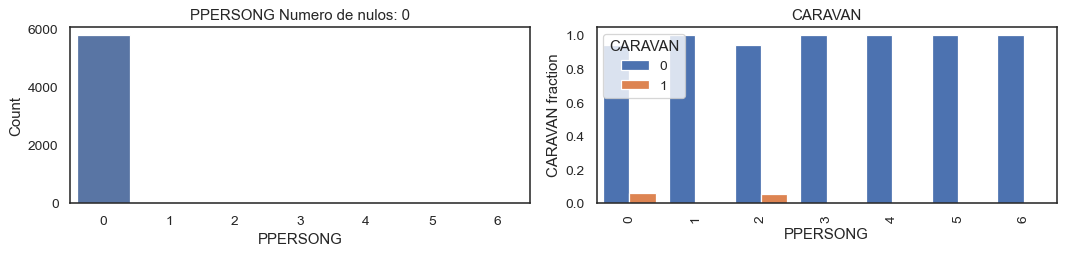

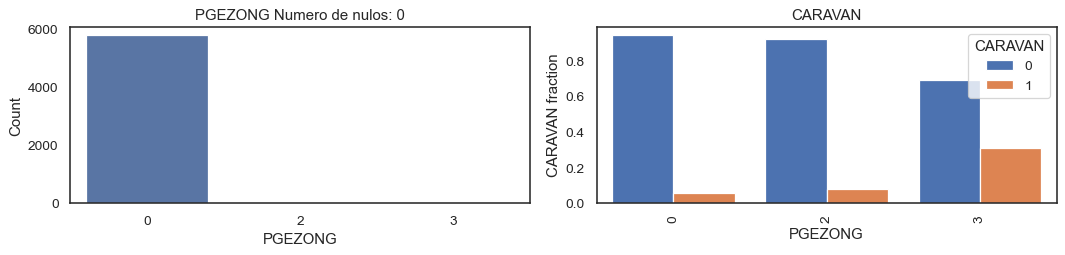

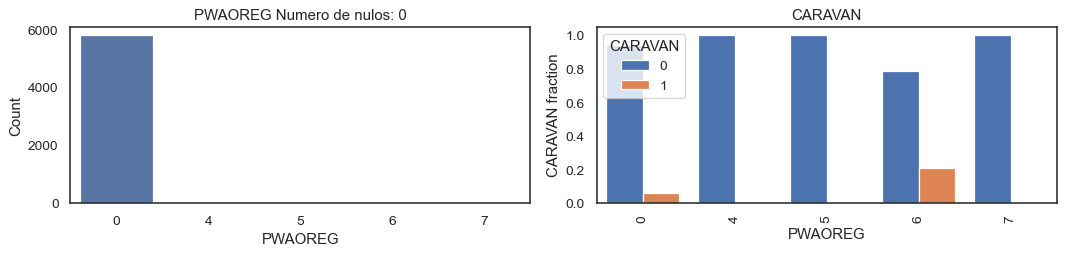

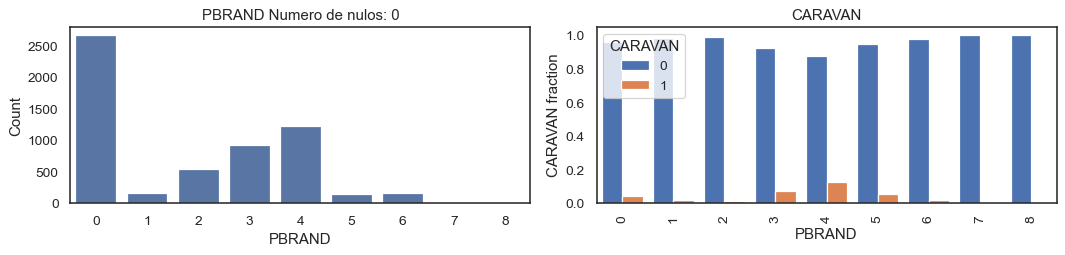

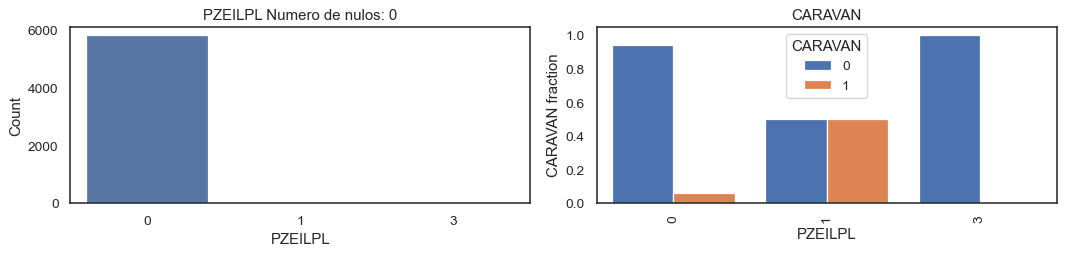

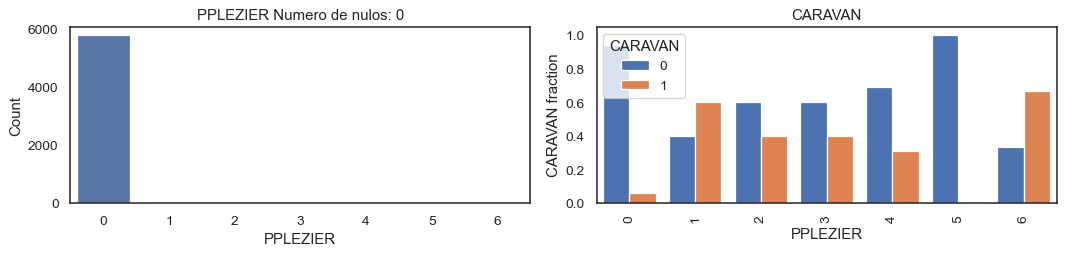

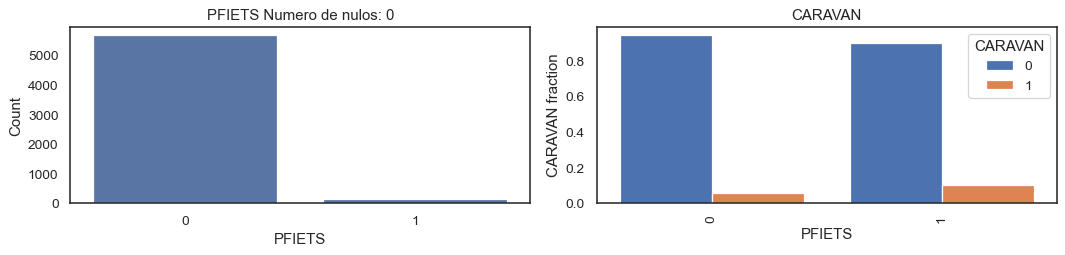

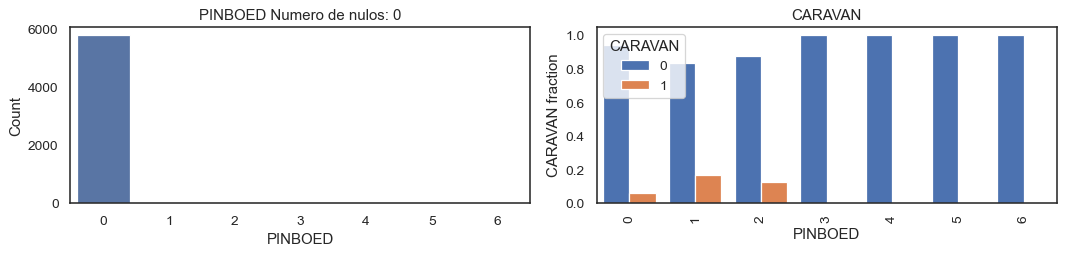

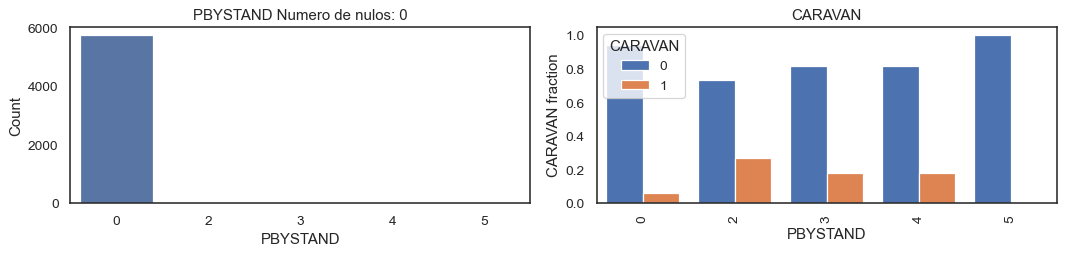

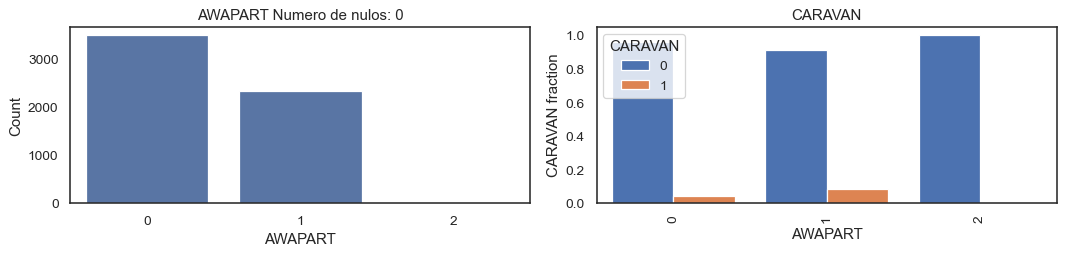

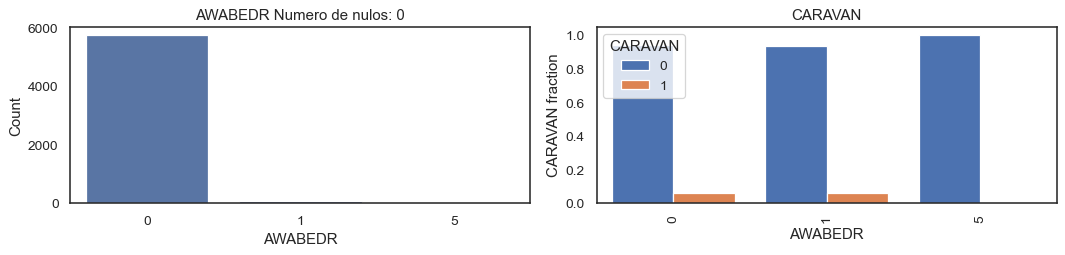

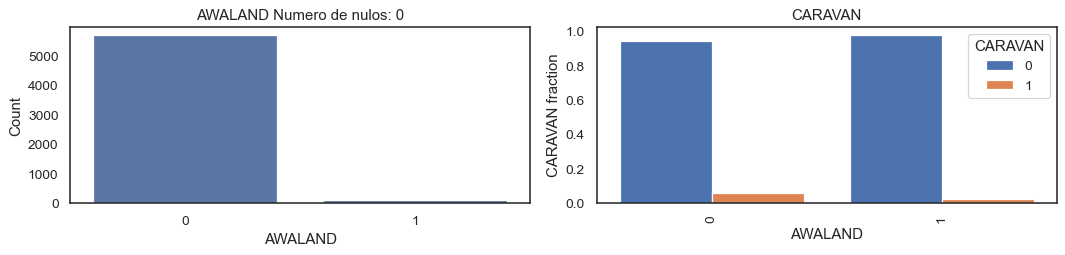

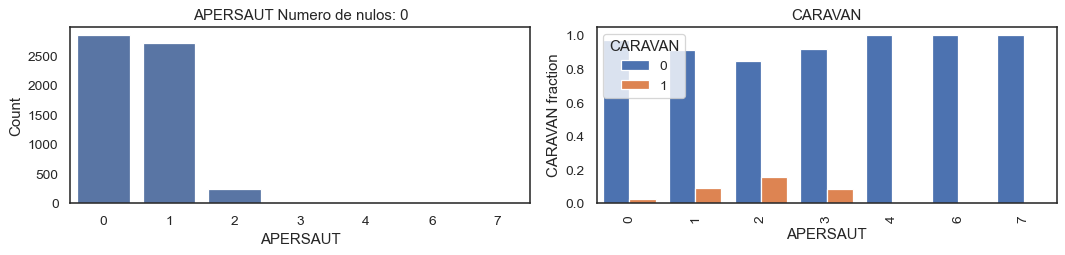

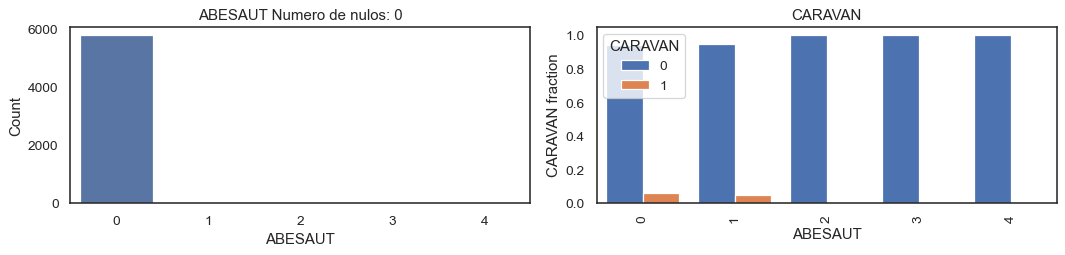

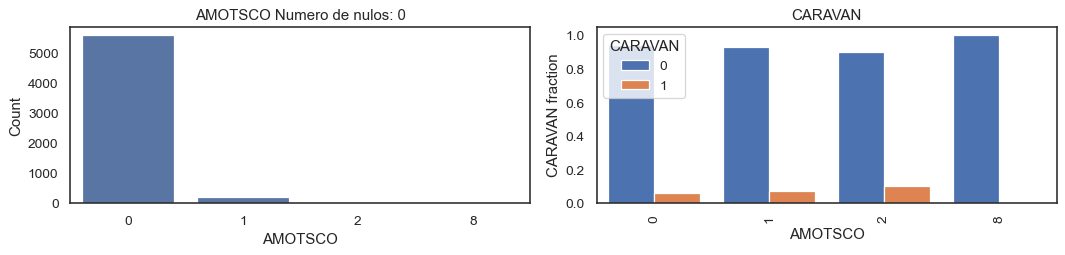

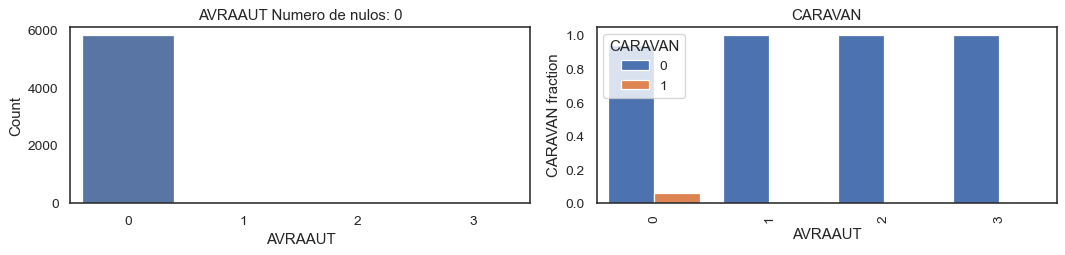

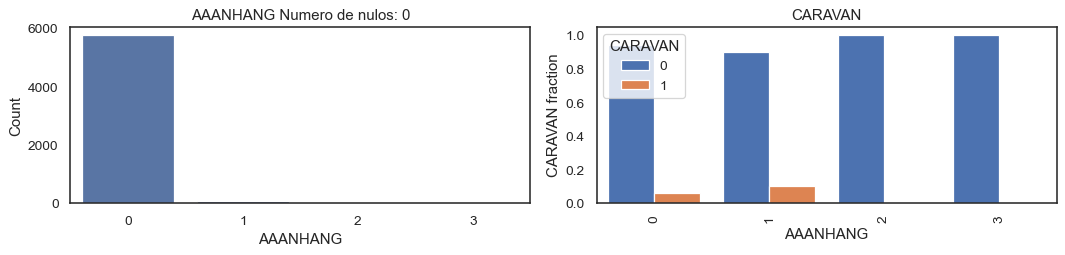

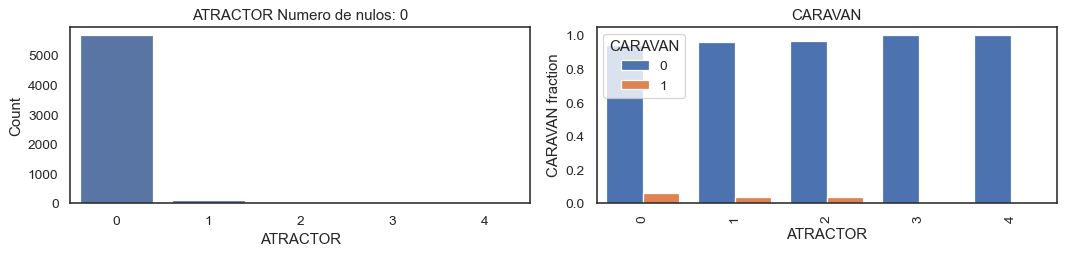

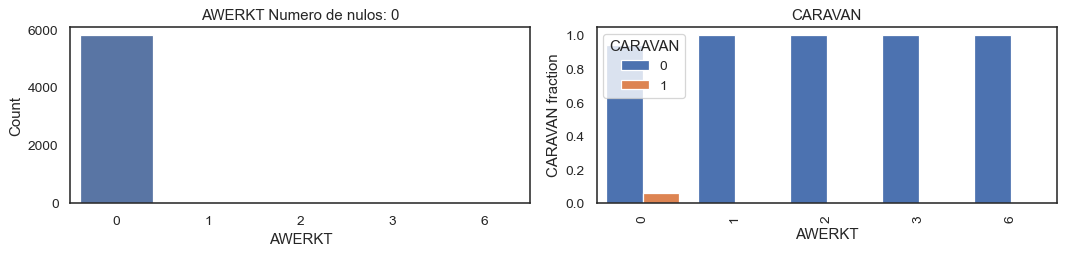

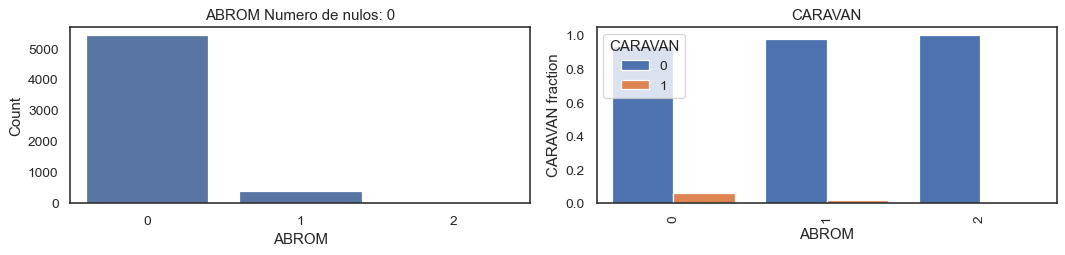

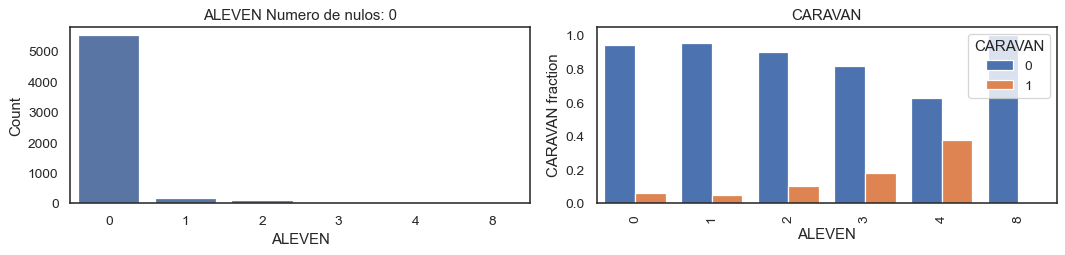

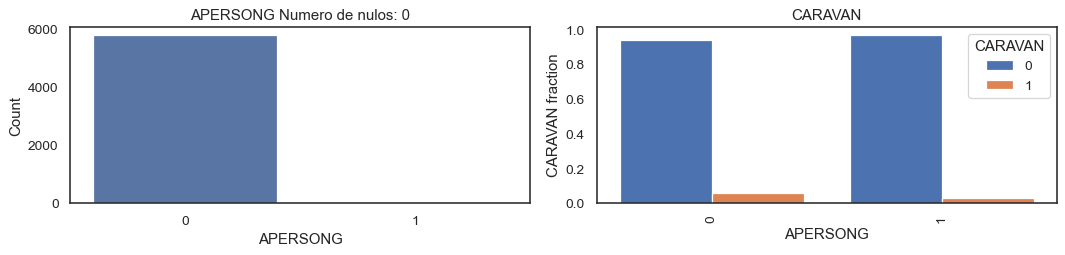

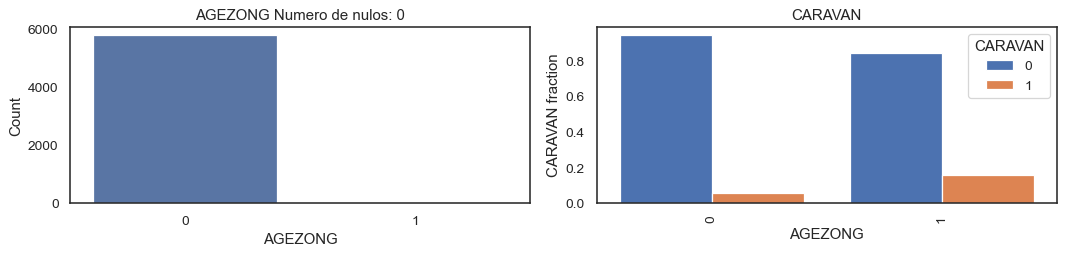

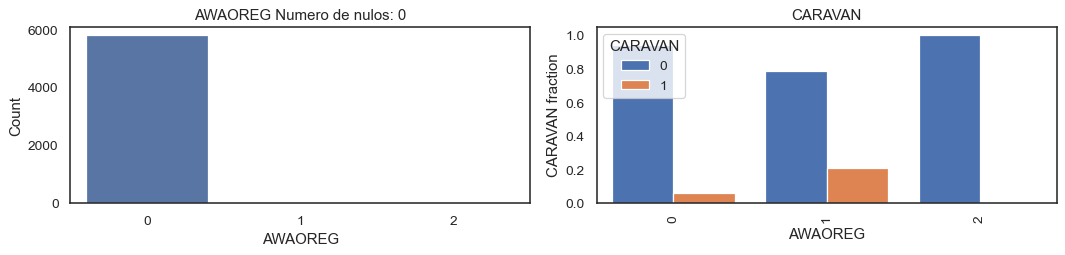

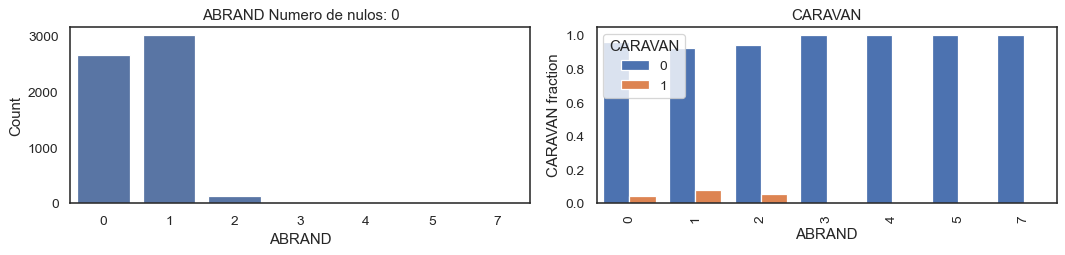

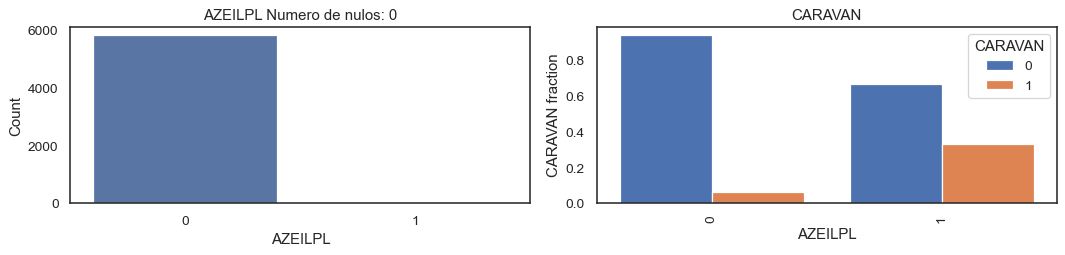

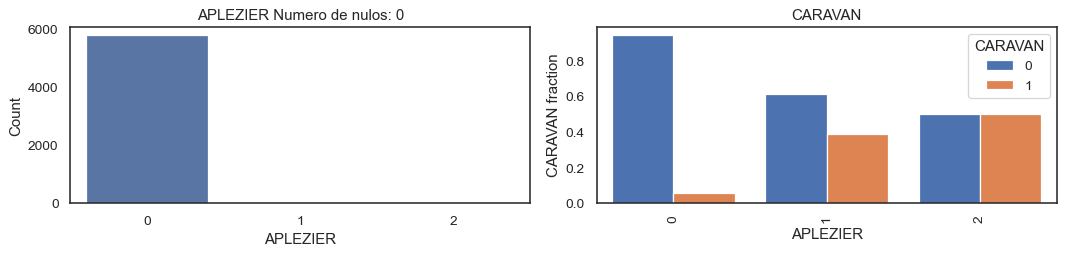

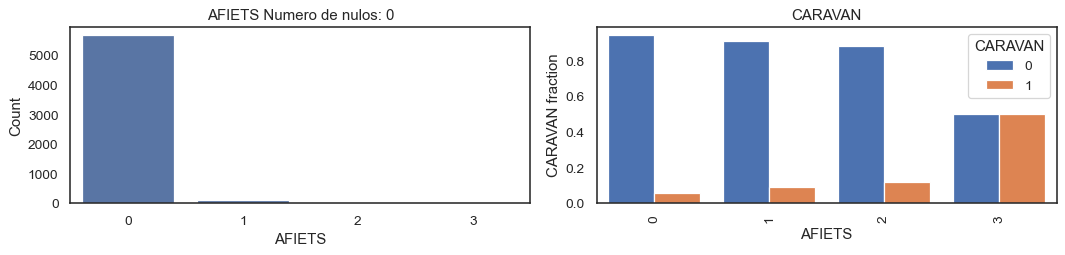

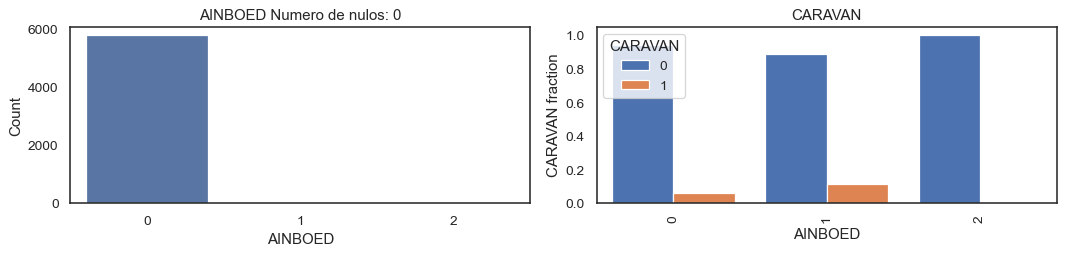

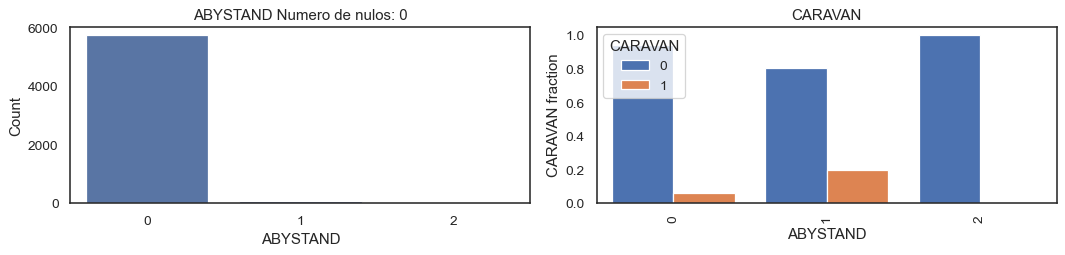

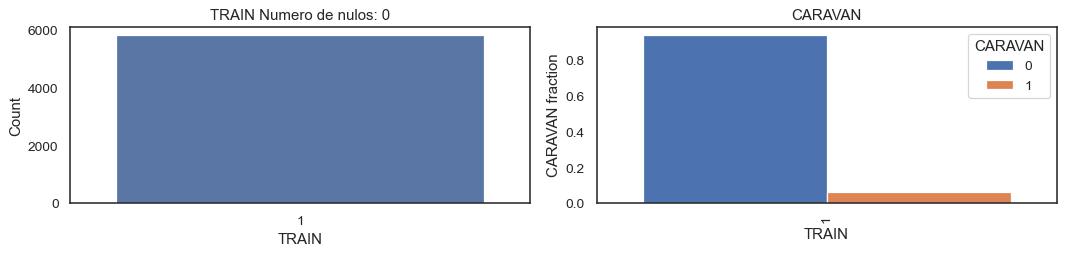

In [33]:
for i in list(df_ticdata.columns):
    if (df_ticdata[i].dtype == float) & (i != 'CARAVAN'):
        plot_feature(df_ticdata, col_name = i, isContinuous = True, target = 'CARAVAN')
    elif  i != 'CARAVAN':
        plot_feature(df_ticdata, col_name = i, isContinuous = False, target = 'CARAVAN')

En estos gráficos podemos ver que variables van a influenciar a nuestro modelo, no hay outlayers, ya que nuestras variables se encuentran entre el 1-12 en las numéricas y el resto de variables son categóricas.
Podemos observar en proporción los posibles interesados en contratar un seguro de caravanas sobre el Data Frame de train.

Casi todas las variables se comportan de una forma parecida, pero habría que destacar el aumento de posibles interesados en los siguientes casos:
- MINK7512 (Income 75.000€-122.000)
- MSKA (Social class A)
- MSKB1 (Social class b1)
- PWAPART (Contributrion of third party insurance)
- MKOOPKLA (purchasing power)
- APLEZIER (Number of boat policies)
- PWAOREG (Contribution of disabilty insurance policies)
- PTRACTOR (Contribution tractor policies)
- AWAOREG (Number of disability insurance policies)
- ABYSTAND (Number of social security insurance policies)

En las siguientes variables el número de posibles interesados puede llegar a alcanzar o superar el 25%, dependiendo del rango en el que se encuentre:

- APLEZIER (Number of boat policies)
- AFIETS (Number of bicycle policies)
- PZEILPL (Contribution surfboard policies)
- ACEILPL (Number of surfboard policies)
- ALEVEN (Number of life insurances)
- PEGEZONG (Contribution disability insurance policies)
- PMOTSCO (Contribution motorcycle/scooter policies) 
- PPLEZIER (Contribution boat policies)

Como la distribución de los valores entre caravana0 y caravana1 es de 95-5%, comprobamos que los valores que están por encima de 0.005 en los caravn1 y entendemos que existen muchos resultados que tengan caravan0 que siguen esa proporción.

Finalmente para la realización de un modelo no recomendamos utilizar MGODRK (Roman catholic), MGODPR (Protestant), MGODOV (Other religion), MGODGE (No religion). Ya que la ley de protección de datos personales, prohibe el uso de este tipo de datos, los cuales pueden discrimar al usuario final a la hora de conseguir un seguro.